<a href="https://colab.research.google.com/github/eigulys/PyPoPu/blob/master/Skriptai/Praktines_dalies_grafikai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
import os
import re
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.fft import fft
from google.colab import files

# @title
def extract_note_name(filename):
    """
    Extract note name from filename that follows format: name+note+velocity
    Example: "piano_C4_127.wav" should return "C4"
    """
    # Common note pattern: letter (A-G) followed by optional # or b, and then a number
    note_pattern = r'[A-G][#b]?\d+'
    matches = re.findall(note_pattern, filename)

    if matches:
        return matches[0]
    else:
        # Fallback: try to extract middle part of filename (assuming name_note_velocity format)
        parts = os.path.splitext(filename)[0].split('_')
        if len(parts) >= 3:
            return parts[1]  # Middle part
        return "Unknown"

def analyze_audio(file_path):
    """
    Analyze audio file to detect frequency and amplitude
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)  # sr=None preserves original sample rate

    # Calculate amplitude
    amplitude_peak = np.max(np.abs(y))
    amplitude_rms = np.sqrt(np.mean(y**2))

    # Calculate frequency using FFT
    n = len(y)
    yf = fft(y)
    # Get the positive frequencies only
    xf = np.linspace(0.0, sr/2, n//2)
    # Get magnitude spectrum
    magnitude_spectrum = 2.0/n * np.abs(yf[0:n//2])

    # Find peak frequency
    peak_freq_idx = np.argmax(magnitude_spectrum)
    fundamental_freq = xf[peak_freq_idx]

    return {
        'frequency': fundamental_freq,
        'amplitude_peak': amplitude_peak,
        'amplitude_rms': amplitude_rms
    }

def plot_waveform_and_spectrum(file_path, title=None):
    """
    Plot the waveform and spectrum of the audio file
    """
    y, sr = librosa.load(file_path, sr=None)

    plt.figure(figsize=(14, 6))

    # Plot waveform
    plt.subplot(2, 1, 1)
    plt.title('Waveform')
    plt.plot(np.arange(len(y))/sr, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot spectrum
    plt.subplot(2, 1, 2)
    plt.title('Spectrum')
    n = len(y)
    yf = fft(y)
    xf = np.linspace(0.0, sr/2, n//2)
    plt.plot(xf, 2.0/n * np.abs(yf[0:n//2]))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    if title:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

def main():
    print("Upload audio files (WAV, MP3, etc.) for analysis")
    uploaded = files.upload()  # This will prompt user to upload files

    results = []

    for filename, content in uploaded.items():
        print(f"Processing: {filename}")

        # Save the file temporarily
        with open(filename, 'wb') as f:
            f.write(content)

        # Extract note name
        note_name = extract_note_name(filename)

        # Analyze audio
        analysis_results = analyze_audio(filename)

        # Plot waveform and spectrum
        plot_waveform_and_spectrum(filename, f"{filename} - Note: {note_name}")

        # Collect results
        results.append({
            'filename': filename,
            'note_name': note_name,
            'frequency': analysis_results['frequency'],
            'amplitude_peak': analysis_results['amplitude_peak'],
            'amplitude_rms': analysis_results['amplitude_rms']
        })

    # Create DataFrame and export to CSV
    if results:
        df = pd.DataFrame(results)
        csv_filename = 'audio_analysis_results.csv'
        df.to_csv(csv_filename, index=False)
        print(f"Analysis complete! Results saved to {csv_filename}")

        # Display results as table
        print("\nAnalysis Results:")
        print(df)

        # Make CSV available for download
        files.download(csv_filename)
    else:
        print("No files were analyzed.")

if __name__ == "__main__":
    main()

# VCO Tracking
Analizuojamas aplankas įrašomas rankiniu būdu

In [1]:
# @title

import os
import numpy as np
import pandas as pd
import librosa
from scipy.fft import fft
from datetime import datetime
from google.colab import drive

def parse_filename(filename):
    """
    Parse filename with format: synth_date_time.extension
    Example: "prophet_20250312_142015.wav" -> ("prophet", "20250312", "142015")
    """
    base_name = os.path.splitext(filename)[0]
    parts = base_name.split('_')

    if len(parts) >= 3:
        synth_name = parts[0]
        date_str = parts[1]
        time_str = parts[2]
        return synth_name, date_str, time_str
    else:
        return "Unknown", "Unknown", "Unknown"

def get_timestamp(date_str, time_str):
    """
    Convert date and time strings to a datetime object
    """
    try:
        timestamp_str = f"{date_str}_{time_str}"
        return datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
    except ValueError:
        # Return a far future date if parsing fails
        return datetime.max

def get_note_name(index):
    """
    Get note name based on index, starting from C0
    """
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = index // 12
    note_index = index % 12
    return f"{notes[note_index]}{octave}"

def get_theoretical_frequency(note_index):
    """
    Calculate theoretical frequency for a note
    C0 is index 0, which is MIDI note 12
    Formula: f = 440 * 2^((n-69)/12) where n is MIDI note number
    """
    midi_number = 12 + note_index  # C0 is MIDI note 12
    return 440 * (2 ** ((midi_number - 69) / 12))

def analyze_audio(file_path):
    """
    Analyze audio file to detect frequency and amplitude
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)  # sr=None preserves original sample rate

    # Calculate amplitude
    amplitude_peak = np.max(np.abs(y))
    amplitude_rms = np.sqrt(np.mean(y**2))

    # Calculate frequency using FFT
    n = len(y)
    yf = fft(y)
    # Get the positive frequencies only
    xf = np.linspace(0.0, sr/2, n//2)
    # Get magnitude spectrum
    magnitude_spectrum = 2.0/n * np.abs(yf[0:n//2])

    # Find peak frequency
    peak_freq_idx = np.argmax(magnitude_spectrum)
    fundamental_freq = xf[peak_freq_idx]

    return {
        'frequency': fundamental_freq,
        'amplitude_peak': amplitude_peak,
        'amplitude_rms': amplitude_rms
    }

def main():
    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Define the folder path
    folder_path = '/content/drive/MyDrive/Bakalauras/VCO/YuSynth_22'
    print(f"Accessing files from: {folder_path}")

    # Check if path exists
    if not os.path.exists(folder_path):
        print(f"Error: Path '{folder_path}' not found. Please check the folder path.")
        return

    # Get all audio files from the folder
    audio_extensions = ('.wav', '.mp3', '.flac', '.aiff', '.ogg')
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(audio_extensions)]

    if not files:
        print(f"No audio files found in {folder_path}")
        return

    print(f"Found {len(files)} audio files")

    file_infos = []

    # First pass: parse filenames and collect timestamps
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        synth_name, date_str, time_str = parse_filename(filename)
        timestamp = get_timestamp(date_str, time_str)

        file_infos.append({
            'filename': filename,
            'file_path': file_path,
            'synth_name': synth_name,
            'date_str': date_str,
            'time_str': time_str,
            'timestamp': timestamp
        })

    # Sort files by timestamp
    file_infos.sort(key=lambda x: x['timestamp'])

    results = []

    # Second pass: analyze audio and assign notes
    for i, file_info in enumerate(file_infos):
        filename = file_info['filename']
        file_path = file_info['file_path']
        print(f"Processing: {filename}")

        # Assign note name based on index (chronological order)
        note_name = get_note_name(i)

        # Calculate theoretical frequency
        theoretical_freq = get_theoretical_frequency(i)

        # Analyze audio
        analysis_results = analyze_audio(file_path)

        # Collect results
        results.append({
            'note_name': note_name,
            'measured_frequency': analysis_results['frequency'],
            'theoretical_frequency': theoretical_freq,
            'measured_amplitude_peak': analysis_results['amplitude_peak'],
            'measured_amplitude_rms': analysis_results['amplitude_rms']
        })

    # Create DataFrame from analysis results
    if results:
        df = pd.DataFrame(results)

        # Get synth name and date for the CSV filename and metadata
        if file_infos:
            synth_name = file_infos[0]['synth_name']
            date_str = file_infos[0]['date_str']
            csv_filename = f"{synth_name}_{date_str}_analysis.csv"
        else:
            synth_name = "Unknown"
            date_str = "Unknown"
            csv_filename = 'audio_analysis_results.csv'

        # Create CSV with metadata in the first two rows
        csv_path = os.path.join(folder_path, csv_filename)

        # Create metadata rows
        with open(csv_path, 'w') as f:
            f.write(f"Synth Name,{synth_name}\n")
            f.write(f"Recording Date,{date_str}\n")

        # Append the analysis results
        df.to_csv(csv_path, mode='a', index=False)

        print(f"Analysis complete! Results saved to {csv_path}")

        # Display results as table
        print("\nAnalysis Results:")
        print(f"Synth Name: {synth_name}")
        print(f"Recording Date: {date_str}")
        print(df)
    else:
        print("No files were analyzed.")

if __name__ == "__main__":
    main()

Mounting Google Drive...
Mounted at /content/drive
Accessing files from: /content/drive/MyDrive/Bakalauras/VCO/YuSynth_22
Found 121 audio files
Processing: Yusynth_22_250410_202346.wav
Processing: Yusynth_22_250410_202348.wav
Processing: Yusynth_22_250410_202350.wav
Processing: Yusynth_22_250410_202352.wav
Processing: Yusynth_22_250410_202354.wav
Processing: Yusynth_22_250410_202356.wav
Processing: Yusynth_22_250410_202358.wav
Processing: Yusynth_22_250410_202400.wav
Processing: Yusynth_22_250410_202402.wav
Processing: Yusynth_22_250410_202404.wav
Processing: Yusynth_22_250410_202406.wav
Processing: Yusynth_22_250410_202408.wav
Processing: Yusynth_22_250410_202410.wav
Processing: Yusynth_22_250410_202412.wav
Processing: Yusynth_22_250410_202414.wav
Processing: Yusynth_22_250410_202416.wav
Processing: Yusynth_22_250410_202418.wav
Processing: Yusynth_22_250410_202420.wav
Processing: Yusynth_22_250410_202422.wav
Processing: Yusynth_22_250410_202424.wav
Processing: Yusynth_22_250410_202426

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
import os
import re

# Mount Google Drive
drive.mount('/content/drive')

def analyze_vco_data(file_path):
    """
    Analyze VCO tuning data from CSV file with semicolon separators.

    Parameters:
    file_path (str): Path to the CSV file in Google Drive
    """
    # Load the data with semicolon delimiter
    print(f"Loading data from: {file_path}")

    # First, read the file to extract metadata from the first rows
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Extract metadata from first lines
    synth_name = lines[0].split(';')[1] if len(lines) > 0 else "Unknown"
    recording_date = lines[1].split(';')[1] if len(lines) > 1 else "Unknown"

    print(f"Synth Name: {synth_name}")
    print(f"Recording Date: {recording_date}")

    # Skip the metadata rows and read the actual data
    df = pd.read_csv(file_path, sep=';', skiprows=2)

    # Display first few rows to understand the data structure
    print("\nData preview:")
    print(df.head())
    print("\nColumn names:", df.columns.tolist())

    # Calculate frequency deviation
    df['freq_deviation'] = df['measured_frequency'] - df['theoretical_frequency']
    df['freq_deviation_percent'] = (df['freq_deviation'] / df['theoretical_frequency']) * 100

    # Create lists for x-axis management
    notes = df['note_name'].tolist()
    x_positions = np.arange(len(notes))

    # Identify C notes (assuming standard notation where C notes start with "C" and are followed by a number)
    is_c_note = ['C' == note[0] and len(note) > 1 and note[1].isdigit() for note in notes]
    c_note_indices = [i for i, is_c in enumerate(is_c_note) if is_c]
    c_note_labels = [notes[i] for i in c_note_indices]

    # Create a figure with dual y-axes - Frequency Deviation and RMS Amplitude
    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")

    ax1 = plt.gca()
    deviation_bars = ax1.bar(x_positions, df['freq_deviation'].abs(),
                           alpha=0.7, color='royalblue', label='Frequency Deviation (Hz)')

    # Set logarithmic scale for primary y-axis (deviation)
    ax1.set_yscale('log')

    # Secondary axis - RMS Amplitude
    ax2 = ax1.twinx()
    rms_line = ax2.plot(x_positions, df['measured_amplitude_rms'],
                       'o-', color='green', label='RMS Amplitude')

    # Set logarithmic scale for secondary y-axis (amplitude)
    ax2.set_yscale('log')

    # Set all x-ticks but only label the C notes
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([''] * len(notes))

    # Apply C note labels at their correct positions
    for i, label in zip(c_note_indices, c_note_labels):
        ax1.xaxis.get_major_ticks()[i].label1.set_visible(True)
        ax1.xaxis.get_major_ticks()[i].label1.set_text(label)
        ax1.xaxis.get_major_ticks()[i].label1.set_fontweight('bold')

    # Adding vertical lines at C notes for reference
    for i in c_note_indices:
        ax1.axvline(x=i, color='gray', linestyle='--', alpha=0.3)

    # Adding labels and title
    title = f"VCO Tuning Analysis: {synth_name}"
    subtitle = f"Recorded on: {recording_date}"

    ax1.set_xlabel('Note Name (C notes only)', fontsize=12)
    ax1.set_ylabel('Frequency Deviation (Hz) - Log Scale', color='royalblue', fontsize=12)
    ax2.set_ylabel('RMS Amplitude - Log Scale', color='green', fontsize=12)
    plt.title(f"{title}\n{subtitle}", fontsize=14)

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Set grid for better readability
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('vco_deviation_and_amplitude_log.png', dpi=300)

    # Percentage deviation plot with logarithmic y-axis
    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")

    # Use absolute percentage deviation for logarithmic scale
    abs_deviation_pct = np.abs(df['freq_deviation_percent'])

    # Create bars with color indicating direction (positive/negative)
    bar_colors = ['red' if val < 0 else 'blue' for val in df['freq_deviation_percent']]

    # Create bars with absolute values for log scale
    ax = plt.gca()
    bars = ax.bar(x_positions, abs_deviation_pct, alpha=0.85, color=bar_colors)

    # Set logarithmic scale for y-axis
    ax.set_yscale('log')

    # Add custom label to indicate positive/negative
    for i, val in enumerate(df['freq_deviation_percent']):
        if abs(val) > 0.1:  # Only label significant deviations
            sign = "+" if val > 0 else "-"
            ax.text(i, abs_deviation_pct[i], sign,
                   ha='center', va='bottom', fontweight='bold')

    # Set all x-ticks but only label the C notes
    ax.set_xticks(x_positions)
    ax.set_xticklabels([''] * len(notes))

    # Apply C note labels at their correct positions
    for i, label in zip(c_note_indices, c_note_labels):
        ax.xaxis.get_major_ticks()[i].label1.set_visible(True)
        ax.xaxis.get_major_ticks()[i].label1.set_text(label)
        ax.xaxis.get_major_ticks()[i].label1.set_fontweight('bold')

    # Adding vertical lines at C notes for reference
    for i in c_note_indices:
        ax.axvline(x=i, color='gray', linestyle='--', alpha=0.3)

    # Create custom legend for positive/negative values
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', edgecolor='blue', alpha=0.85, label='Higher than theoretical'),
        Patch(facecolor='red', edgecolor='red', alpha=0.85, label='Lower than theoretical')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_xlabel('Note Name (C notes only)', fontsize=12)
    ax.set_ylabel('Absolute Frequency Deviation (%) - Log Scale', fontsize=12)
    ax.set_title(f'VCO Tuning Analysis: Percentage Frequency Deviation\n{synth_name} - {recording_date}', fontsize=14)

    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add reference lines
    ax.axhline(y=0.1, color='black', linestyle='--', alpha=0.7)
    ax.text(len(notes)-1, 0.1, '0.1% reference', va='bottom', ha='right', color='black', alpha=0.7)

    plt.tight_layout()
    plt.savefig('vco_percentage_deviation_log.png', dpi=300)

    # Create a scatter plot showing relationship between frequency and deviation with log axes
    plt.figure(figsize=(12, 10))

    scatter = plt.scatter(df['theoretical_frequency'], np.abs(df['freq_deviation_percent']),
                         c=df['measured_amplitude_rms'], cmap='viridis',
                         alpha=0.7, s=60, edgecolor='k', linewidth=0.5)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('RMS Amplitude')

    # Add reference line at 0.1% deviation
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='0.1% Tolerance')

    # Label C notes on the plot
    for i, row in df.iterrows():
        if row['note_name'][0] == 'C' and len(row['note_name']) > 1 and row['note_name'][1].isdigit():
            plt.annotate(row['note_name'],
                        (row['theoretical_frequency'], np.abs(row['freq_deviation_percent'])),
                        textcoords="offset points",
                        xytext=(5,0),
                        ha='left',
                        fontweight='bold')

    plt.xscale('log')  # Log scale for frequency axis
    plt.yscale('log')  # Log scale for deviation percentage
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xlabel('Theoretical Frequency (Hz) - Log Scale', fontsize=12)
    plt.ylabel('Absolute Frequency Deviation (%) - Log Scale', fontsize=12)
    plt.title(f'VCO Tuning Deviation vs Frequency\n{synth_name} - {recording_date}',
              fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.savefig('vco_freq_vs_deviation_log.png', dpi=300)

    # Statistical summary
    print("\nStatistical summary of frequency deviation:")
    print(df['freq_deviation'].describe())

    print("\nNotes with largest deviation (absolute):")
    df_sorted = df.iloc[np.abs(df['freq_deviation_percent']).argsort()[::-1]]
    print(df_sorted[['note_name', 'theoretical_frequency', 'measured_frequency', 'freq_deviation', 'freq_deviation_percent']].head(5))

    return df

# Default path - change this to the actual path of your CSV file
default_file_path = '/content/drive/MyDrive/Bakalauras/Arturia/vco_data.csv'

# Function to let the user specify a different path
def analyze_custom_file():
    print("Current default path:", default_file_path)
    custom_path = input("Enter the path to your CSV file (or press Enter to use the default path): ")

    if not custom_path:
        custom_path = default_file_path

    if not os.path.exists(custom_path):
        print(f"Error: File not found at {custom_path}")
        return None

    return analyze_vco_data(custom_path)

# Run the analysis
analyzed_data = analyze_custom_file()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current default path: /content/drive/MyDrive/Bakalauras/Arturia/vco_data.csv


KeyboardInterrupt: Interrupted by user

Dažnio ir amplitudės stabilumo analize. V1

In [ ]:
# @title
!pip install librosa soundfile matplotlib

import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, hilbert
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Get folder path from user
folder_path = input("Enter the full path to your Google Drive folder: ")

# Signal processing parameters
SMOOTHING_WINDOW = 5  # Odd number for median filtering
MIN_PEAK_DISTANCE = 100  # Samples (adjust based on expected frequency)

def process_audio(file_path):
    # Load audio with high precision
    y, sr = librosa.load(file_path, sr=None, mono=True)

    # Preprocessing
    y = y - np.mean(y)  # DC offset removal
    y = y / np.max(np.abs(y))  # Normalization

    # Low-pass filtering
    b, a = butter(4, 0.1, btype='low')
    y_filtered = filtfilt(b, a, y)

    # Differentiate the signal to emphasize edges
    diff_signal = np.diff(y_filtered)

    # Find rising edges using zero-crossings of differentiated signal
    zero_crossings = np.where(np.diff(np.sign(diff_signal)) > 0)[0]

    # Validate zero crossings
    if len(zero_crossings) < 101:
        raise ValueError(f"Not enough cycles found: {len(zero_crossings)} detected")

    # Select 101 crossings from the stable portion
    start_idx = len(zero_crossings) // 2 - 50
    selected_crossings = zero_crossings[start_idx:start_idx + 101]

    # Calculate periods and frequencies
    periods = np.diff(selected_crossings) / sr
    frequencies = 1.0 / periods

    # Calculate amplitudes (peak-to-peak)
    amplitudes = []
    for i in range(len(selected_crossings) - 1):
        start = selected_crossings[i]
        end = selected_crossings[i+1]
        amplitudes.append(np.max(y[start:end]) - np.min(y[start:end]))

    return {
        'frequencies': frequencies,
        'amplitudes': amplitudes,
        'sample_rate': sr,
        'zero_crossings': selected_crossings
    }

data_list = []

for file in [f for f in os.listdir(folder_path) if f.lower().endswith(('.wav', '.mp3', '.ogg', '.flac'))]:
    try:
        file_path = os.path.join(folder_path, file)
        result = process_audio(file_path)

        # Store metrics
        data_list.append({
            'Filename': file,
            'Avg Frequency (Hz)': np.mean(result['frequencies']),
            'Freq Std Dev': np.std(result['frequencies']),
            'Min Frequency': np.min(result['frequencies']),
            'Max Frequency': np.max(result['frequencies']),
            'Avg Amplitude': np.mean(result['amplitudes']),
            'Amp Std Dev': np.std(result['amplitudes']),
            'Sample Rate': result['sample_rate']
        })

        # Optional: Visual verification
        plt.figure(figsize=(10, 4))
        plt.plot(result['zero_crossings'][:-1], result['frequencies'], 'ro')
        plt.title(f'Frequency Stability: {file}')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Sample Number')
        plt.show()

        print(f"Processed {file}: {np.mean(result['frequencies']):.2f} ± {np.std(result['frequencies']):.2f} Hz")

    except Exception as e:
        print(f"Error in {file}: {str(e)}")

# Save results
if data_list:
    df = pd.DataFrame(data_list)
    output_path = os.path.join(folder_path, 'improved_analysis.csv')
    df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
else:
    print("\nNo valid files processed.")

# **Frequency Deviation Data Visualization from CSV Files**
I'll create a Python script for Google Colab that reads multiple CSV files from Google Drive and plots frequency deviation data together for comparison.

Step-by-Step Solution
* First, we need to mount Google Drive to access the CSV files
* Read multiple CSV files and extract frequency data
* Plot the data on a single graph with different colors for each file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5 CSV files:
  - Buchla258_VCO_440Hz_30s_Triangle_pitch_analysis.csv
  - Yusynth_VCO_440Hz_30s_Saw_pitch_analysis.csv
  - Minibrute_440Hz_30s_Saw_pitch_analysis.csv
  - Mofos_V2_VCO_440Hz_30s_Saw_pitch_analysis.csv
  - Mofos_VCO_440Hz_30s_Saw_pitch_analysis.csv


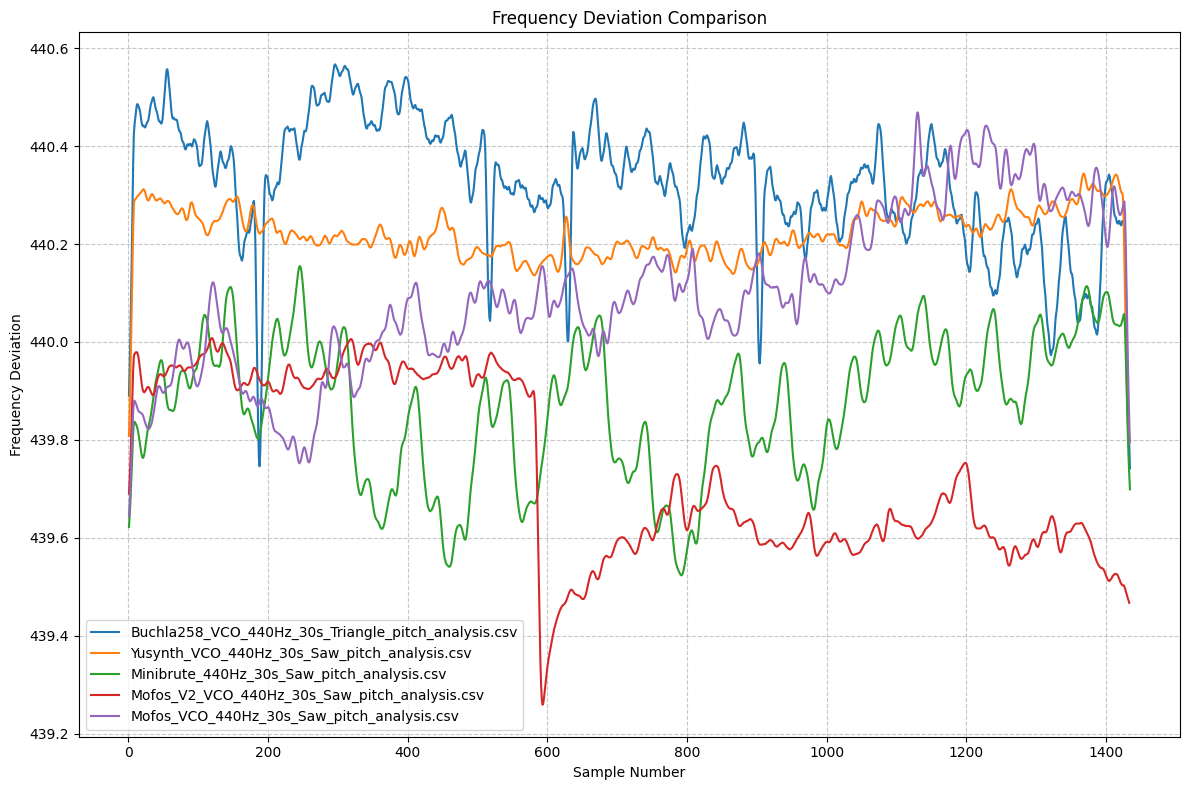

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import glob

# Mount Google Drive
drive.mount('/content/drive')

def read_frequency_data(file_path):
    """
    Read frequency data from CSV file.
    Assumes first column is frequency data, second column is timestamp.
    """
    try:
        # Read CSV file with comma as separator
        data = pd.read_csv(file_path, header=None)

        # If file has only one column with comma as part of the data
        if len(data.columns) == 1:
            data = pd.read_csv(file_path, sep=',', header=None)

        # Extract frequency data (first column)
        frequency_data = data.iloc[:, 0].values

        return frequency_data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def plot_frequency_deviation(csv_files):
    """
    Plot frequency deviation data from multiple CSV files on the same graph.
    """
    plt.figure(figsize=(12, 8))

    # Color map for multiple lines
    colors = plt.cm.tab10.colors

    for i, file_path in enumerate(csv_files):
        # Read data
        frequency_data = read_frequency_data(file_path)

        if frequency_data is not None:
            # Create x-axis as simple counter
            x_values = np.arange(1, len(frequency_data) + 1)

            # Get filename for legend
            file_name = os.path.basename(file_path)

            # Plot data
            plt.plot(x_values, frequency_data,
                     label=file_name,
                     color=colors[i % len(colors)],
                     linewidth=1.5)

    # Add labels and title
    plt.xlabel('Sample Number')
    plt.ylabel('Frequency Deviation')
    plt.title('Frequency Deviation Comparison')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Specify the folder path where your CSV files are stored
# Change this to your actual folder path in Google Drive
csv_folder = '/content/drive/MyDrive/Bakalauras/Daznio_data'  # Update this path!

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))

if not csv_files:
    print(f"No CSV files found in {csv_folder}")
else:
    print(f"Found {len(csv_files)} CSV files:")
    for file in csv_files:
        print(f"  - {os.path.basename(file)}")

    # Plot the data
    plot_frequency_deviation(csv_files)

Papildyta versija

In [2]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import glob
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import math

# Mount Google Drive (run this only once per session)
drive.mount('/content/drive')

# Set the fixed folder path
DEFAULT_FOLDER_PATH = "/content/drive/MyDrive/Bakalauras/Daznio_data"

def read_frequency_data(file_path, column_index=0):
    """
    Read frequency data from CSV file.
    Args:
        file_path: Path to the CSV file
        column_index: Index of the column containing frequency data (default: 0)
    """
    try:
        # First try standard comma separation
        try:
            data = pd.read_csv(file_path, header=None)
        except:
            # If that fails, try explicit comma separator
            data = pd.read_csv(file_path, sep=',', header=None)

        # Make sure we have data and the column index is valid
        if data.empty:
            print(f"Warning: No data found in {file_path}")
            return None

        if column_index >= len(data.columns):
            print(f"Warning: Column index {column_index} out of range for {file_path}. Using column 0 instead.")
            column_index = 0

        # Extract frequency data from specified column
        frequency_data = data.iloc[:, column_index].values

        return frequency_data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def apply_smoothing(data, method, params):
    """
    Apply smoothing to the data using specified method and parameters.

    Args:
        data: The frequency data to smooth
        method: The smoothing method to use
        params: Dictionary of parameters for the smoothing method

    Returns:
        Smoothed data
    """
    if method == 'none' or data is None or len(data) < 3:
        return data

    try:
        if method == 'moving_average':
            window_size = params.get('window_size', 5)
            # Ensure window size is valid
            window_size = min(window_size, len(data))
            if window_size < 2:
                return data
            return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

        elif method == 'savgol':
            window_size = params.get('window_size', 11)
            poly_order = params.get('poly_order', 3)

            # Make sure window_size is odd
            if window_size % 2 == 0:
                window_size += 1

            # Make sure window_size is valid
            window_size = min(window_size, len(data) - 1)

            # Make sure poly_order is valid
            poly_order = min(poly_order, window_size - 1)

            if window_size < 3:
                return data

            return savgol_filter(data, window_size, poly_order)

        elif method == 'gaussian':
            sigma = params.get('sigma', 20.0)  # Updated default to 20.0
            return gaussian_filter1d(data, sigma)

    except Exception as e:
        print(f"Error applying smoothing: {e}")
        return data

    return data

def plot_frequency_deviation(csv_files, options=None, custom_labels=None):
    """
    Plot frequency deviation data from multiple CSV files on the same graph.

    Args:
        csv_files: List of CSV file paths
        options: Dictionary of plotting options
        custom_labels: Dictionary mapping file paths to custom labels
    """
    if not csv_files:
        print("No files to plot!")
        return

    if options is None:
        options = {}

    if custom_labels is None:
        custom_labels = {}

    # Default options
    default_options = {
        'figsize': (14, 8),
        'xlabel': 'Imties numeris',        # Updated default
        'ylabel': 'Dažnis, Hz',            # Updated default
        'title': 'Dažnio stabilumas',      # Updated default
        'grid': True,
        'linewidth': 1.5,
        'normalize': False,                # Option to normalize data
        'column_index': 0,                 # Column index for frequency data
        'smooth_method': 'gaussian',       # Default smoothing method is gaussian
        'show_original': False,            # Show original data as dotted line
        'smooth_params': {'sigma': 20.0},  # Updated default sigma to 20.0
        'dpi': 100,                        # Resolution of the plot
        'show_smoothed_label': False       # Updated default to False
    }

    # Update defaults with provided options
    for key, value in options.items():
        default_options[key] = value

    options = default_options

    # Create plot
    plt.figure(figsize=options['figsize'], dpi=options['dpi'])

    # Color map for multiple lines
    colors = plt.cm.tab10.colors
    legend_items_count = 0  # Count number of lines for legend column handling

    # Process and display each file
    for i, file_path in enumerate(csv_files):
        # Read data
        print(f"Processing file: {os.path.basename(file_path)}")
        frequency_data = read_frequency_data(file_path, options['column_index'])

        if frequency_data is None or len(frequency_data) == 0:
            print(f"  - Skipping {file_path}: No valid data")
            continue

        print(f"  - Loaded {len(frequency_data)} data points")

        # Normalize data if requested
        if options['normalize']:
            frequency_data = (frequency_data - np.mean(frequency_data)) / np.std(frequency_data)
            print(f"  - Data normalized")

        # Create x-axis as simple counter
        x_values = np.arange(1, len(frequency_data) + 1)

        # Get filename for legend
        file_name = os.path.basename(file_path)

        # Use custom label if available
        display_name = custom_labels.get(file_path, file_name)

        # Apply smoothing
        if options['smooth_method'] != 'none':
            print(f"  - Applying {options['smooth_method']} smoothing")

        smoothed_data = apply_smoothing(
            frequency_data,
            options['smooth_method'],
            options['smooth_params']
        )

        if smoothed_data is None:
            print(f"  - Smoothing failed, using original data")
            smoothed_data = frequency_data

        # Adjust x-values for smoothed data if lengths differ
        if len(smoothed_data) != len(frequency_data):
            smoothed_x = np.linspace(1, len(frequency_data), len(smoothed_data))
            print(f"  - Adjusted x-axis for smoothed data ({len(smoothed_data)} points)")
        else:
            smoothed_x = x_values

        # Show original data if requested
        if options['show_original'] and options['smooth_method'] != 'none':
            plt.plot(x_values, frequency_data,
                     color=colors[i % len(colors)],
                     linestyle=':',
                     alpha=0.5,
                     linewidth=options['linewidth'] * 0.7,
                     label=f"{display_name} (original)")
            print(f"  - Plotted original data")
            legend_items_count += 1

        # Plot smoothed data with or without the "(smoothed)" label based on option
        if options['smooth_method'] == 'none' or not options['show_smoothed_label']:
            label = f"{display_name}"
        else:
            label = f"{display_name} (smoothed)"

        plt.plot(smoothed_x, smoothed_data,
                 label=label,
                 color=colors[i % len(colors)],
                 linewidth=options['linewidth'])
        print(f"  - Plotted smoothed data")
        legend_items_count += 1

    # Add labels and title
    plt.xlabel(options['xlabel'])
    plt.ylabel(options['ylabel'])
    plt.title(options['title'])

    if options['grid']:
        plt.grid(True, linestyle='--', alpha=0.7)

    # Configure legend based on number of items
    if legend_items_count > 5:
        # Calculate optimal number of columns
        ncol = min(3, math.ceil(legend_items_count / 3))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=ncol)
    else:
        plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Print final message before showing plot
    print(f"Displaying plot with {len(csv_files)} files")

    # Show plot
    plt.show()

def list_csv_files():
    """List all CSV files in the default folder"""
    csv_files = glob.glob(os.path.join(DEFAULT_FOLDER_PATH, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {DEFAULT_FOLDER_PATH}")
    else:
        print(f"Found {len(csv_files)} CSV files in {DEFAULT_FOLDER_PATH}:")
        for file in csv_files:
            print(f"  - {os.path.basename(file)}")

    return csv_files

# Interactive UI for selecting folder and files with smoothing options
def create_interactive_ui():
    # Plot options
    title_input = widgets.Text(
        value='Dažnio stabilumas',     # Updated default
        description='Plot Title:',
        style={'description_width': 'initial'}
    )

    # X and Y axis title inputs
    x_axis_title = widgets.Text(
        value='Imties numeris',         # Updated default
        description='X-Axis Title:',
        style={'description_width': 'initial'}
    )

    y_axis_title = widgets.Text(
        value='Dažnis, Hz',             # Updated default
        description='Y-Axis Title:',
        style={'description_width': 'initial'}
    )

    normalize_checkbox = widgets.Checkbox(
        value=False,
        description='Normalize Data',
        style={'description_width': 'initial'}
    )

    column_index = widgets.IntSlider(
        value=0,
        min=0,
        max=5,
        step=1,
        description='Frequency Column:',
        style={'description_width': 'initial'}
    )

    linewidth = widgets.FloatSlider(
        value=1.5,
        min=0.5,
        max=4.0,
        step=0.5,
        description='Line Width:',
        style={'description_width': 'initial'}
    )

    # Smoothing options
    smooth_method = widgets.Dropdown(
        options=[
            ('None', 'none'),
            ('Moving Average', 'moving_average'),
            ('Savitzky-Golay', 'savgol'),
            ('Gaussian', 'gaussian')
        ],
        value='gaussian',
        description='Smoothing:',
        style={'description_width': 'initial'}
    )

    show_original = widgets.Checkbox(
        value=False,
        description='Show Original Data',
        style={'description_width': 'initial'}
    )

    # Add checkbox for toggling "(smoothed)" in legend
    show_smoothed_label = widgets.Checkbox(
        value=False,                    # Updated default to False
        description='Show "smoothed" in Legend',
        style={'description_width': 'initial'}
    )

    # Moving average window size
    ma_window_size = widgets.IntSlider(
        value=5,
        min=2,
        max=30,
        step=1,
        description='Window Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=True
    )

    # Savitzky-Golay parameters
    sg_window_size = widgets.IntSlider(
        value=11,
        min=5,
        max=51,
        step=2,  # Force odd numbers
        description='Window Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=True
    )

    sg_poly_order = widgets.IntSlider(
        value=3,
        min=1,
        max=5,
        step=1,
        description='Polynomial Order:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=True
    )

    # Gaussian smoothing
    gaussian_sigma = widgets.FloatSlider(
        value=20.0,                     # Updated default to 20.0
        min=0.5,
        max=40.0,                       # Increased max value to accommodate higher default
        step=0.5,
        description='Sigma:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=False
    )

    # Output DPI (resolution)
    dpi_slider = widgets.IntSlider(
        value=100,
        min=72,
        max=300,
        step=1,
        description='Plot DPI:',
        style={'description_width': 'initial'}
    )

    # Create output widgets
    smoothing_params_output = widgets.Output()
    files_output = widgets.Output()
    plot_output = widgets.Output()

    file_widgets = []  # Will store tuples of (filepath, checkbox, label_widget)

    # Function to update which smoothing parameters are shown
    def update_smoothing_params(change):
        with smoothing_params_output:
            smoothing_params_output.clear_output()

            method = change.new

            # Reset all to disabled
            ma_window_size.disabled = True
            sg_window_size.disabled = True
            sg_poly_order.disabled = True
            gaussian_sigma.disabled = True

            # Enable only relevant parameters
            if method == 'moving_average':
                ma_window_size.disabled = False
                display(ma_window_size)
            elif method == 'savgol':
                sg_window_size.disabled = False
                sg_poly_order.disabled = False
                display(sg_window_size)
                display(sg_poly_order)
            elif method == 'gaussian':
                gaussian_sigma.disabled = False
                display(gaussian_sigma)

            # Show/hide original data checkbox and smoothed label checkbox
            show_original.disabled = (method == 'none')
            show_smoothed_label.disabled = (method == 'none')

    # Register the callback
    smooth_method.observe(update_smoothing_params, names='value')

    # Scan for files immediately (no button needed)
    with files_output:
        csv_files = list_csv_files()

        if not csv_files:
            print(f"No CSV files found in {DEFAULT_FOLDER_PATH}")
        else:
            print(f"Select files to plot:")

            # Create a container for file selection
            file_container = widgets.VBox([])
            file_widgets = []

            for file in csv_files:
                filename = os.path.basename(file)

                # Create checkbox for file selection
                checkbox = widgets.Checkbox(
                    value=True,
                    description='',
                    style={'description_width': 'initial'},
                    layout=widgets.Layout(width='40px')
                )

                # Create text input for custom label
                label_widget = widgets.Text(
                    value=filename,  # Default to filename
                    placeholder='Custom label',
                    description='',
                    layout=widgets.Layout(width='70%')
                )

                # Create a horizontal layout for checkbox and label
                file_row = widgets.HBox([
                    checkbox,
                    widgets.Label(value=filename, layout=widgets.Layout(width='200px')),
                    widgets.Label(value=' → Label: '),
                    label_widget
                ])

                file_widgets.append((file, checkbox, label_widget))
                file_container.children = (*file_container.children, file_row)

            display(file_container)

            # Button to plot
            plot_button = widgets.Button(
                description='Plot Selected Files',
                button_style='success'
            )

            def on_plot_button_clicked(b):
                with plot_output:
                    plot_output.clear_output()

                    # Get selected files and their custom labels
                    selected_files = []
                    custom_labels = {}

                    for file_path, checkbox, label_widget in file_widgets:
                        if checkbox.value:
                            selected_files.append(file_path)
                            custom_labels[file_path] = label_widget.value

                    if not selected_files:
                        print("No files selected for plotting.")
                        return

                    # Get smoothing parameters based on method
                    smooth_params = {}
                    if smooth_method.value == 'moving_average':
                        smooth_params['window_size'] = ma_window_size.value
                    elif smooth_method.value == 'savgol':
                        smooth_params['window_size'] = sg_window_size.value
                        smooth_params['poly_order'] = sg_poly_order.value
                    elif smooth_method.value == 'gaussian':
                        smooth_params['sigma'] = gaussian_sigma.value

                    # Plotting options
                    options = {
                        'title': title_input.value,
                        'xlabel': x_axis_title.value,
                        'ylabel': y_axis_title.value,
                        'normalize': normalize_checkbox.value,
                        'column_index': column_index.value,
                        'linewidth': linewidth.value,
                        'smooth_method': smooth_method.value,
                        'show_original': show_original.value,
                        'show_smoothed_label': show_smoothed_label.value,
                        'smooth_params': smooth_params,
                        'dpi': dpi_slider.value
                    }

                    print(f"Plotting {len(selected_files)} selected files...")
                    plot_frequency_deviation(selected_files, options, custom_labels)

            plot_button.on_click(on_plot_button_clicked)
            display(plot_button)

    # Layout all components
    display(widgets.HTML("<h3>Frequency Deviation Plotter</h3>"))
    display(widgets.HTML(f"<p>Reading from: <b>{DEFAULT_FOLDER_PATH}</b></p>"))

    display(widgets.HTML("<h4>Plot Settings</h4>"))
    display(widgets.HBox([title_input]))
    display(widgets.HBox([x_axis_title, y_axis_title]))
    display(widgets.HBox([column_index, linewidth, dpi_slider]))
    display(widgets.HBox([normalize_checkbox]))

    display(widgets.HTML("<h4>Smoothing Options</h4>"))
    display(widgets.HBox([smooth_method, show_original, show_smoothed_label]))

    # Show gaussian parameters by default
    with smoothing_params_output:
        display(gaussian_sigma)
    display(smoothing_params_output)

    display(widgets.HTML("<h4>Available Files</h4>"))
    display(files_output)

    display(widgets.HTML("<h4>Plot Output</h4>"))
    display(plot_output)

# Simple non-interactive version for direct use
def simple_plot_all_files(smooth_method='gaussian', smooth_params=None):
    """
    Simple function to plot all CSV files with basic options.
    Useful for quick plotting without using the interactive UI.
    """
    csv_files = list_csv_files()

    if not csv_files:
        print(f"No CSV files found in {DEFAULT_FOLDER_PATH}")
        return

    if smooth_params is None:
        smooth_params = {'sigma': 20.0}  # Updated default to 20.0

    # Default smooth parameters if not provided
    if smooth_method == 'moving_average' and 'window_size' not in smooth_params:
        smooth_params['window_size'] = 5
    elif smooth_method == 'savgol':
        if 'window_size' not in smooth_params:
            smooth_params['window_size'] = 11
        if 'poly_order' not in smooth_params:
            smooth_params['poly_order'] = 3
    elif smooth_method == 'gaussian' and 'sigma' not in smooth_params:
        smooth_params['sigma'] = 20.0  # Updated default to 20.0

    options = {
        'title': 'Dažnio stabilumas',     # Updated default
        'xlabel': 'Imties numeris',       # Updated default
        'ylabel': 'Dažnis, Hz',           # Updated default
        'smooth_method': smooth_method,
        'smooth_params': smooth_params,
        'show_original': False,
        'show_smoothed_label': False      # Updated default to False
    }

    plot_frequency_deviation(csv_files, options)

# Run the interactive UI by default
print(f"Loading frequency deviation plotter for {DEFAULT_FOLDER_PATH}...")
create_interactive_ui()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading frequency deviation plotter for /content/drive/MyDrive/Bakalauras/Daznio_data...


HTML(value='<h3>Frequency Deviation Plotter</h3>')

HTML(value='<p>Reading from: <b>/content/drive/MyDrive/Bakalauras/Daznio_data</b></p>')

HTML(value='<h4>Plot Settings</h4>')

HTML(value='<h4>Smoothing Options</h4>')

Output()

HTML(value='<h4>Available Files</h4>')

Output()

HTML(value='<h4>Plot Output</h4>')

Output()

# Frequency Deviation Plotter with Smoothing Options

In [4]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import glob
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import math

# Mount Google Drive (run this only once per session)
drive.mount('/content/drive')

# Set the fixed folder path
DEFAULT_FOLDER_PATH = "/content/drive/MyDrive/Bakalauras/Daznio_data"

def read_frequency_data(file_path, column_index=0):
    """
    Read frequency data from CSV file.
    Args:
        file_path: Path to the CSV file
        column_index: Index of the column containing frequency data (default: 0)
    """
    try:
        # First try standard comma separation
        try:
            data = pd.read_csv(file_path, header=None)
        except:
            # If that fails, try explicit comma separator
            data = pd.read_csv(file_path, sep=',', header=None)

        # Make sure we have data and the column index is valid
        if data.empty:
            print(f"Warning: No data found in {file_path}")
            return None

        if column_index >= len(data.columns):
            print(f"Warning: Column index {column_index} out of range for {file_path}. Using column 0 instead.")
            column_index = 0

        # Extract frequency data from specified column
        frequency_data = data.iloc[:, column_index].values

        return frequency_data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def apply_smoothing(data, method, params):
    """
    Apply smoothing to the data using specified method and parameters.

    Args:
        data: The frequency data to smooth
        method: The smoothing method to use
        params: Dictionary of parameters for the smoothing method

    Returns:
        Smoothed data
    """
    if method == 'none' or data is None or len(data) < 3:
        return data

    try:
        if method == 'moving_average':
            window_size = params.get('window_size', 5)
            # Ensure window size is valid
            window_size = min(window_size, len(data))
            if window_size < 2:
                return data
            return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

        elif method == 'savgol':
            window_size = params.get('window_size', 11)
            poly_order = params.get('poly_order', 3)

            # Make sure window_size is odd
            if window_size % 2 == 0:
                window_size += 1

            # Make sure window_size is valid
            window_size = min(window_size, len(data) - 1)

            # Make sure poly_order is valid
            poly_order = min(poly_order, window_size - 1)

            if window_size < 3:
                return data

            return savgol_filter(data, window_size, poly_order)

        elif method == 'gaussian':
            sigma = params.get('sigma', 20.0)  # Updated default to 20.0
            return gaussian_filter1d(data, sigma)

    except Exception as e:
        print(f"Error applying smoothing: {e}")
        return data

    return data

def plot_frequency_deviation(csv_files, options=None, custom_labels=None):
    """
    Plot frequency deviation data from multiple CSV files on the same graph.

    Args:
        csv_files: List of CSV file paths
        options: Dictionary of plotting options
        custom_labels: Dictionary mapping file paths to custom labels
    """
    if not csv_files:
        print("No files to plot!")
        return

    if options is None:
        options = {}

    if custom_labels is None:
        custom_labels = {}

    # Default options
    default_options = {
        'figsize': (14, 8),
        'xlabel': 'Imties numeris',        # Updated default
        'ylabel': 'Dažnis, Hz',            # Updated default
        'title': 'Dažnio stabilumas',      # Updated default
        'grid': True,
        'linewidth': 1.5,
        'normalize': False,                # Option to normalize data
        'column_index': 0,                 # Column index for frequency data
        'smooth_method': 'gaussian',       # Default smoothing method is gaussian
        'show_original': False,            # Show original data as dotted line
        'smooth_params': {'sigma': 20.0},  # Updated default sigma to 20.0
        'dpi': 100,                        # Resolution of the plot
        'show_smoothed_label': False       # Updated default to False
    }

    # Update defaults with provided options
    for key, value in options.items():
        default_options[key] = value

    options = default_options

    # Create plot
    plt.figure(figsize=options['figsize'], dpi=options['dpi'])

    # Color map for multiple lines
    colors = plt.cm.tab10.colors
    legend_items_count = 0  # Count number of lines for legend column handling

    # Process and display each file
    for i, file_path in enumerate(csv_files):
        # Read data
        print(f"Processing file: {os.path.basename(file_path)}")
        frequency_data = read_frequency_data(file_path, options['column_index'])

        if frequency_data is None or len(frequency_data) == 0:
            print(f"  - Skipping {file_path}: No valid data")
            continue

        print(f"  - Loaded {len(frequency_data)} data points")

        # Normalize data if requested
        if options['normalize']:
            frequency_data = (frequency_data - np.mean(frequency_data)) / np.std(frequency_data)
            print(f"  - Data normalized")

        # Create x-axis as simple counter
        x_values = np.arange(1, len(frequency_data) + 1)

        # Get filename for legend
        file_name = os.path.basename(file_path)

        # Use custom label if available
        display_name = custom_labels.get(file_path, file_name)

        # Apply smoothing
        if options['smooth_method'] != 'none':
            print(f"  - Applying {options['smooth_method']} smoothing")

        smoothed_data = apply_smoothing(
            frequency_data,
            options['smooth_method'],
            options['smooth_params']
        )

        if smoothed_data is None:
            print(f"  - Smoothing failed, using original data")
            smoothed_data = frequency_data

        # Adjust x-values for smoothed data if lengths differ
        if len(smoothed_data) != len(frequency_data):
            smoothed_x = np.linspace(1, len(frequency_data), len(smoothed_data))
            print(f"  - Adjusted x-axis for smoothed data ({len(smoothed_data)} points)")
        else:
            smoothed_x = x_values

        # Show original data if requested
        if options['show_original'] and options['smooth_method'] != 'none':
            plt.plot(x_values, frequency_data,
                     color=colors[i % len(colors)],
                     linestyle=':',
                     alpha=0.5,
                     linewidth=options['linewidth'] * 0.7,
                     label=f"{display_name} (original)")
            print(f"  - Plotted original data")
            legend_items_count += 1

        # Plot smoothed data with or without the "(smoothed)" label based on option
        if options['smooth_method'] == 'none' or not options['show_smoothed_label']:
            label = f"{display_name}"
        else:
            label = f"{display_name} (smoothed)"

        plt.plot(smoothed_x, smoothed_data,
                 label=label,
                 color=colors[i % len(colors)],
                 linewidth=options['linewidth'])
        print(f"  - Plotted smoothed data")
        legend_items_count += 1

    # Add labels and title
    plt.xlabel(options['xlabel'])
    plt.ylabel(options['ylabel'])
    plt.title(options['title'])

    if options['grid']:
        plt.grid(True, linestyle='--', alpha=0.7)

    # Configure legend based on number of items
    if legend_items_count > 5:
        # Calculate optimal number of columns
        ncol = min(3, math.ceil(legend_items_count / 3))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=ncol)
    else:
        plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Print final message before showing plot
    print(f"Displaying plot with {len(csv_files)} files")

    # Show plot
    plt.show()

def list_csv_files():
    """List all CSV files in the default folder"""
    csv_files = glob.glob(os.path.join(DEFAULT_FOLDER_PATH, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {DEFAULT_FOLDER_PATH}")
    else:
        print(f"Found {len(csv_files)} CSV files in {DEFAULT_FOLDER_PATH}:")
        for file in csv_files:
            print(f"  - {os.path.basename(file)}")

    return csv_files

# Interactive UI for selecting folder and files with smoothing options
def create_interactive_ui():
    # Plot options
    title_input = widgets.Text(
        value='Dažnio stabilumas',     # Updated default
        description='Plot Title:',
        style={'description_width': 'initial'}
    )

    # X and Y axis title inputs
    x_axis_title = widgets.Text(
        value='Imties numeris',         # Updated default
        description='X-Axis Title:',
        style={'description_width': 'initial'}
    )

    y_axis_title = widgets.Text(
        value='Dažnis, Hz',             # Updated default
        description='Y-Axis Title:',
        style={'description_width': 'initial'}
    )

    normalize_checkbox = widgets.Checkbox(
        value=False,
        description='Normalize Data',
        style={'description_width': 'initial'}
    )

    column_index = widgets.IntSlider(
        value=0,
        min=0,
        max=5,
        step=1,
        description='Frequency Column:',
        style={'description_width': 'initial'}
    )

    linewidth = widgets.FloatSlider(
        value=1.5,
        min=0.5,
        max=4.0,
        step=0.5,
        description='Line Width:',
        style={'description_width': 'initial'}
    )

    # Smoothing options
    smooth_method = widgets.Dropdown(
        options=[
            ('None', 'none'),
            ('Moving Average', 'moving_average'),
            ('Savitzky-Golay', 'savgol'),
            ('Gaussian', 'gaussian')
        ],
        value='gaussian',
        description='Smoothing:',
        style={'description_width': 'initial'}
    )

    show_original = widgets.Checkbox(
        value=False,
        description='Show Original Data',
        style={'description_width': 'initial'}
    )

    # Add checkbox for toggling "(smoothed)" in legend
    show_smoothed_label = widgets.Checkbox(
        value=False,                    # Updated default to False
        description='Show "smoothed" in Legend',
        style={'description_width': 'initial'}
    )

    # Moving average window size
    ma_window_size = widgets.IntSlider(
        value=5,
        min=2,
        max=30,
        step=1,
        description='Window Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=True
    )

    # Savitzky-Golay parameters
    sg_window_size = widgets.IntSlider(
        value=11,
        min=5,
        max=51,
        step=2,  # Force odd numbers
        description='Window Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=True
    )

    sg_poly_order = widgets.IntSlider(
        value=3,
        min=1,
        max=5,
        step=1,
        description='Polynomial Order:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=True
    )

    # Gaussian smoothing
    gaussian_sigma = widgets.FloatSlider(
        value=20.0,                     # Updated default to 20.0
        min=0.5,
        max=40.0,                       # Increased max value to accommodate higher default
        step=0.5,
        description='Sigma:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
        disabled=False
    )

    # Output DPI (resolution)
    dpi_slider = widgets.IntSlider(
        value=100,
        min=72,
        max=300,
        step=1,
        description='Plot DPI:',
        style={'description_width': 'initial'}
    )

    # Create output widgets
    smoothing_params_output = widgets.Output()
    files_output = widgets.Output()
    plot_output = widgets.Output()

    file_widgets = []  # Will store tuples of (filepath, checkbox, label_widget)

    # Function to update which smoothing parameters are shown
    def update_smoothing_params(change):
        with smoothing_params_output:
            smoothing_params_output.clear_output()

            method = change.new

            # Reset all to disabled
            ma_window_size.disabled = True
            sg_window_size.disabled = True
            sg_poly_order.disabled = True
            gaussian_sigma.disabled = True

            # Enable only relevant parameters
            if method == 'moving_average':
                ma_window_size.disabled = False
                display(ma_window_size)
            elif method == 'savgol':
                sg_window_size.disabled = False
                sg_poly_order.disabled = False
                display(sg_window_size)
                display(sg_poly_order)
            elif method == 'gaussian':
                gaussian_sigma.disabled = False
                display(gaussian_sigma)

            # Show/hide original data checkbox and smoothed label checkbox
            show_original.disabled = (method == 'none')
            show_smoothed_label.disabled = (method == 'none')

    # Register the callback
    smooth_method.observe(update_smoothing_params, names='value')

    # Scan for files immediately (no button needed)
    with files_output:
        csv_files = list_csv_files()

        if not csv_files:
            print(f"No CSV files found in {DEFAULT_FOLDER_PATH}")
        else:
            print(f"Select files to plot:")

            # Create a container for file selection
            file_container = widgets.VBox([])
            file_widgets = []

            for file in csv_files:
                filename = os.path.basename(file)

                # Create checkbox for file selection
                checkbox = widgets.Checkbox(
                    value=True,
                    description='',
                    style={'description_width': 'initial'},
                    layout=widgets.Layout(width='40px')
                )

                # Create text input for custom label
                label_widget = widgets.Text(
                    value=filename,  # Default to filename
                    placeholder='Custom label',
                    description='',
                    layout=widgets.Layout(width='70%')
                )

                # Create a horizontal layout for checkbox and label
                file_row = widgets.HBox([
                    checkbox,
                    widgets.Label(value=filename, layout=widgets.Layout(width='200px')),
                    widgets.Label(value=' → Label: '),
                    label_widget
                ])

                file_widgets.append((file, checkbox, label_widget))
                file_container.children = (*file_container.children, file_row)

            display(file_container)

            # Button to plot
            plot_button = widgets.Button(
                description='Plot Selected Files',
                button_style='success'
            )

            def on_plot_button_clicked(b):
                with plot_output:
                    plot_output.clear_output()

                    # Get selected files and their custom labels
                    selected_files = []
                    custom_labels = {}

                    for file_path, checkbox, label_widget in file_widgets:
                        if checkbox.value:
                            selected_files.append(file_path)
                            custom_labels[file_path] = label_widget.value

                    if not selected_files:
                        print("No files selected for plotting.")
                        return

                    # Get smoothing parameters based on method
                    smooth_params = {}
                    if smooth_method.value == 'moving_average':
                        smooth_params['window_size'] = ma_window_size.value
                    elif smooth_method.value == 'savgol':
                        smooth_params['window_size'] = sg_window_size.value
                        smooth_params['poly_order'] = sg_poly_order.value
                    elif smooth_method.value == 'gaussian':
                        smooth_params['sigma'] = gaussian_sigma.value

                    # Plotting options
                    options = {
                        'title': title_input.value,
                        'xlabel': x_axis_title.value,
                        'ylabel': y_axis_title.value,
                        'normalize': normalize_checkbox.value,
                        'column_index': column_index.value,
                        'linewidth': linewidth.value,
                        'smooth_method': smooth_method.value,
                        'show_original': show_original.value,
                        'show_smoothed_label': show_smoothed_label.value,
                        'smooth_params': smooth_params,
                        'dpi': dpi_slider.value
                    }

                    print(f"Plotting {len(selected_files)} selected files...")
                    plot_frequency_deviation(selected_files, options, custom_labels)

            plot_button.on_click(on_plot_button_clicked)
            display(plot_button)

    # Layout all components
    display(widgets.HTML("<h3>Frequency Deviation Plotter</h3>"))
    display(widgets.HTML(f"<p>Reading from: <b>{DEFAULT_FOLDER_PATH}</b></p>"))

    display(widgets.HTML("<h4>Plot Settings</h4>"))
    display(widgets.HBox([title_input]))
    display(widgets.HBox([x_axis_title, y_axis_title]))
    display(widgets.HBox([column_index, linewidth, dpi_slider]))
    display(widgets.HBox([normalize_checkbox]))

    display(widgets.HTML("<h4>Smoothing Options</h4>"))
    display(widgets.HBox([smooth_method, show_original, show_smoothed_label]))

    # Show gaussian parameters by default
    with smoothing_params_output:
        display(gaussian_sigma)
    display(smoothing_params_output)

    display(widgets.HTML("<h4>Available Files</h4>"))
    display(files_output)

    display(widgets.HTML("<h4>Plot Output</h4>"))
    display(plot_output)

# Simple non-interactive version for direct use
def simple_plot_all_files(smooth_method='gaussian', smooth_params=None):
    """
    Simple function to plot all CSV files with basic options.
    Useful for quick plotting without using the interactive UI.
    """
    csv_files = list_csv_files()

    if not csv_files:
        print(f"No CSV files found in {DEFAULT_FOLDER_PATH}")
        return

    if smooth_params is None:
        smooth_params = {'sigma': 20.0}  # Updated default to 20.0

    # Default smooth parameters if not provided
    if smooth_method == 'moving_average' and 'window_size' not in smooth_params:
        smooth_params['window_size'] = 5
    elif smooth_method == 'savgol':
        if 'window_size' not in smooth_params:
            smooth_params['window_size'] = 11
        if 'poly_order' not in smooth_params:
            smooth_params['poly_order'] = 3
    elif smooth_method == 'gaussian' and 'sigma' not in smooth_params:
        smooth_params['sigma'] = 20.0  # Updated default to 20.0

    options = {
        'title': 'Dažnio stabilumas',     # Updated default
        'xlabel': 'Imties numeris',       # Updated default
        'ylabel': 'Dažnis, Hz',           # Updated default
        'smooth_method': smooth_method,
        'smooth_params': smooth_params,
        'show_original': False,
        'show_smoothed_label': False      # Updated default to False
    }

    plot_frequency_deviation(csv_files, options)

# Run the interactive UI by default
print(f"Loading frequency deviation plotter for {DEFAULT_FOLDER_PATH}...")
create_interactive_ui()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading frequency deviation plotter for /content/drive/MyDrive/Bakalauras/Daznio_data...


HTML(value='<h3>Frequency Deviation Plotter</h3>')

HTML(value='<p>Reading from: <b>/content/drive/MyDrive/Bakalauras/Daznio_data</b></p>')

HTML(value='<h4>Plot Settings</h4>')

HTML(value='<h4>Smoothing Options</h4>')

Output()

HTML(value='<h4>Available Files</h4>')

Output()

HTML(value='<h4>Plot Output</h4>')

Output()

# Python Script for VCO Pitch Tracking and Amplitude Data Analysis

* Mounts your Google Drive
* Reads multiple CSV files from the specified folder
* Extracts frequency (2nd column) and amplitude (4th column) data
* Creates two plots:
* * One combined graph for frequency data from all files
* * One graph for amplitude data from all files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


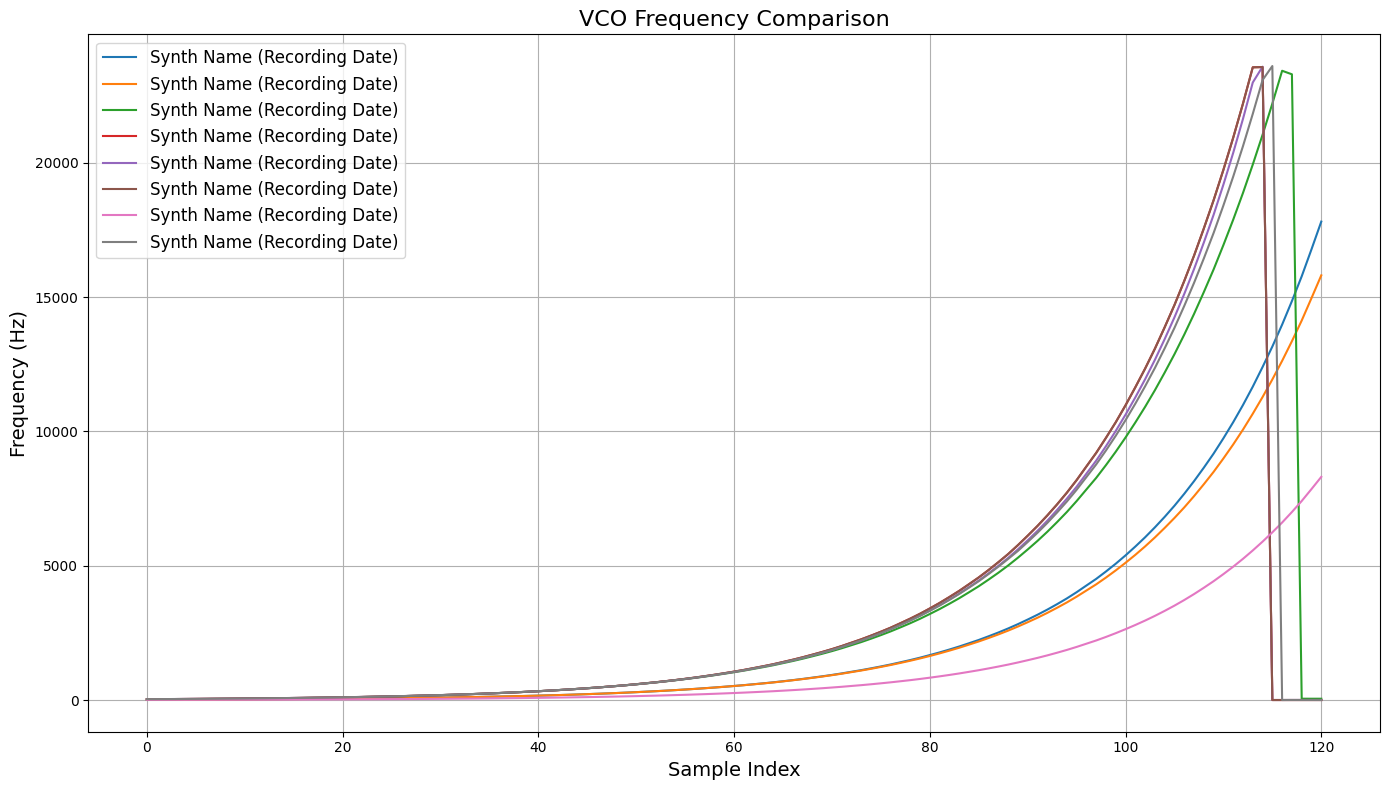

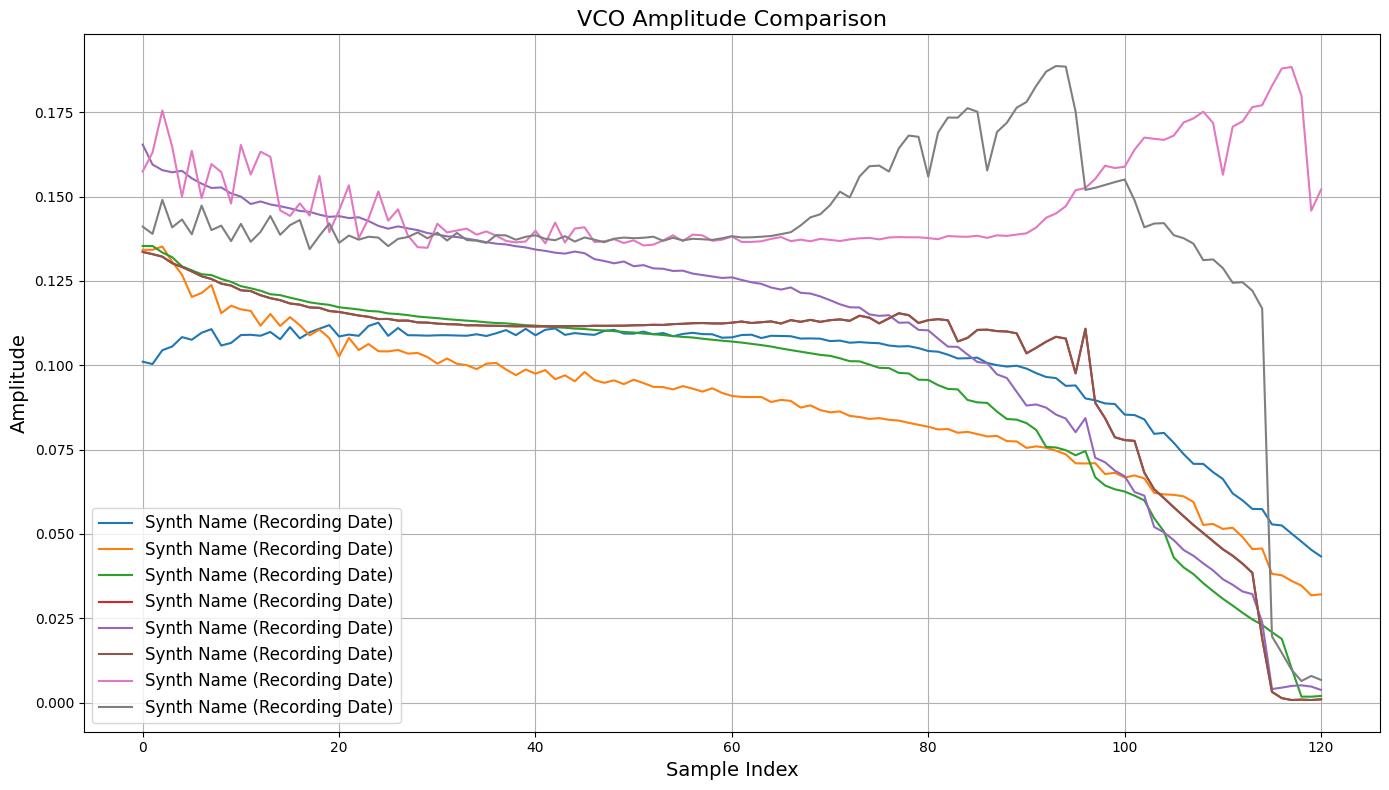

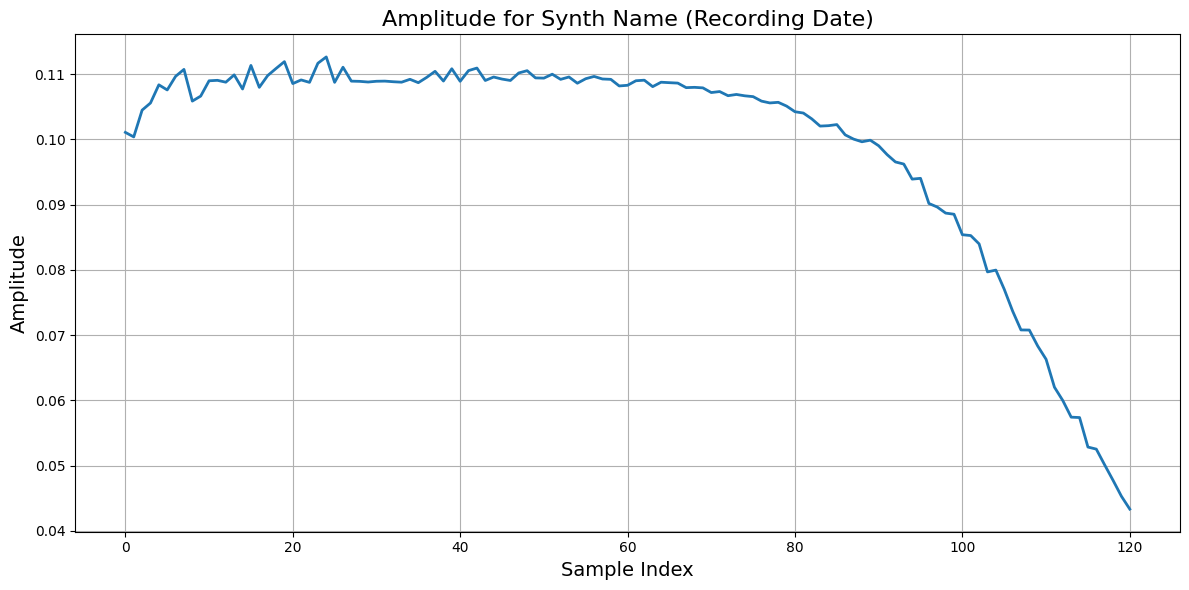

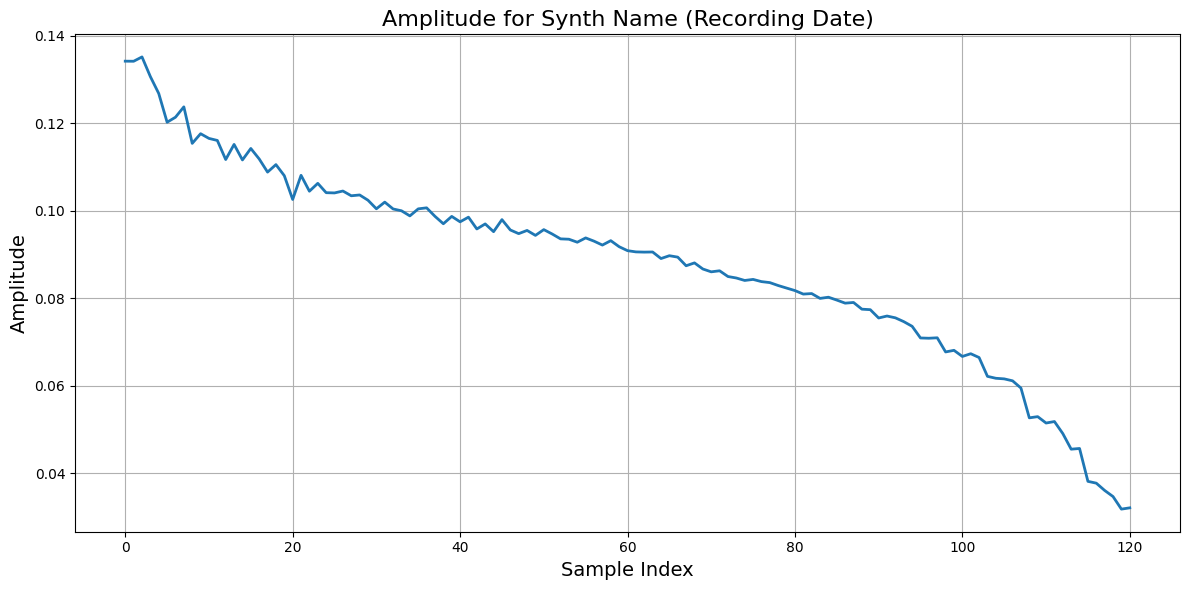

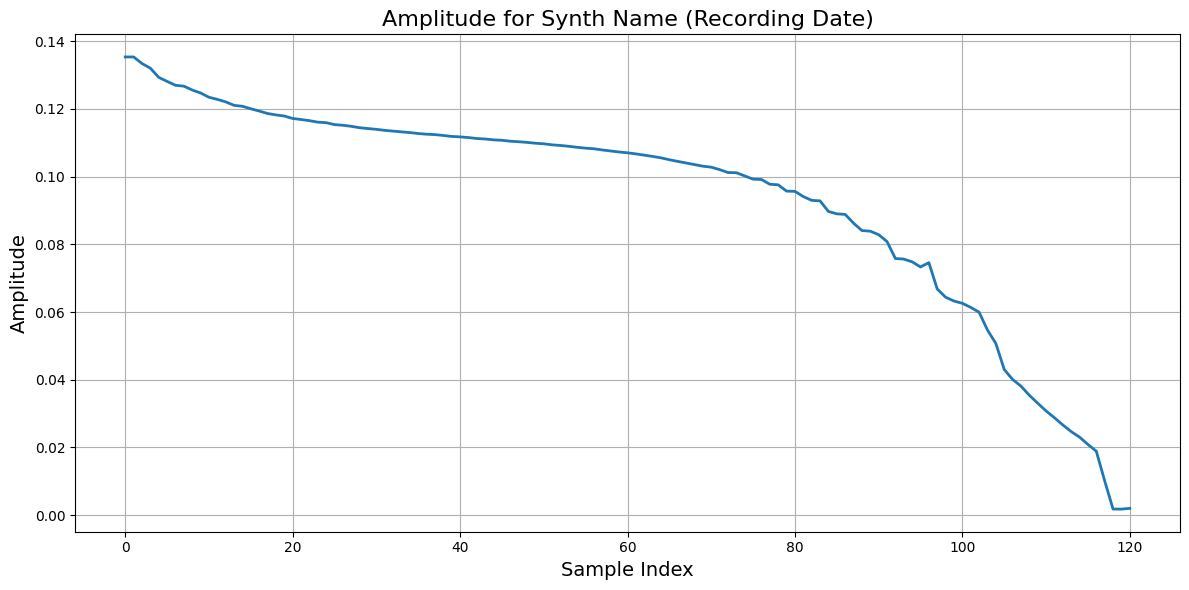

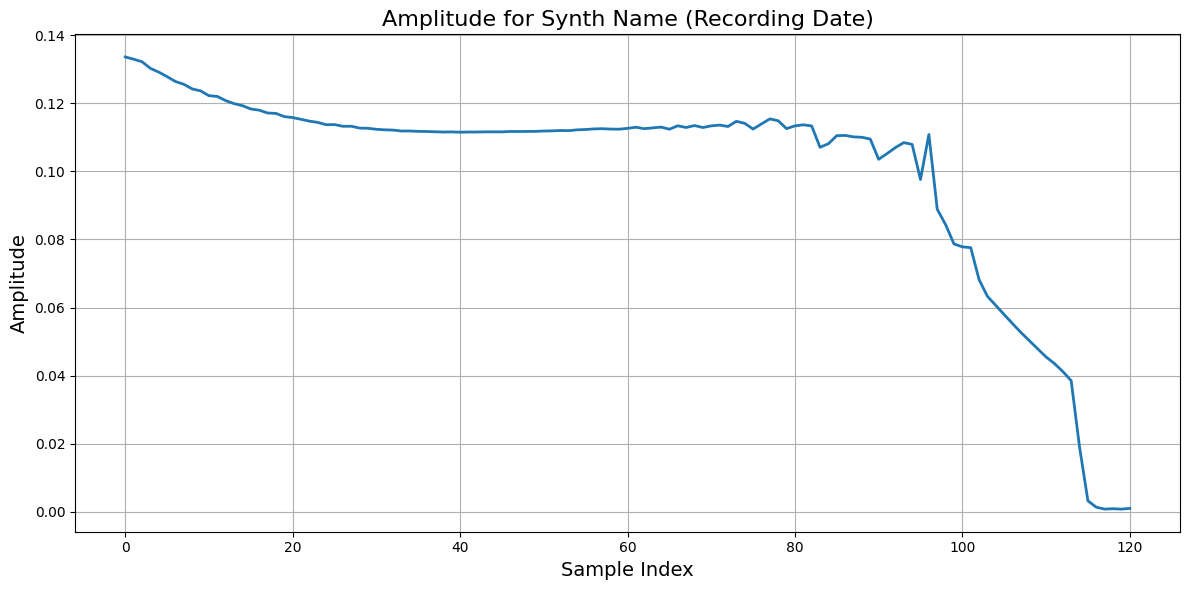

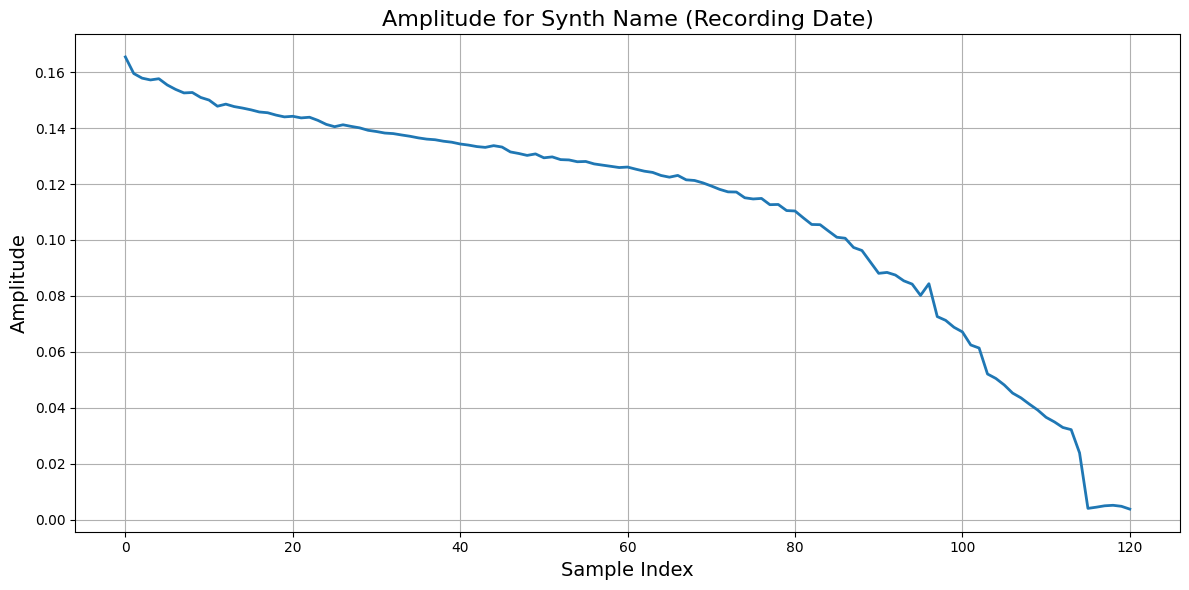

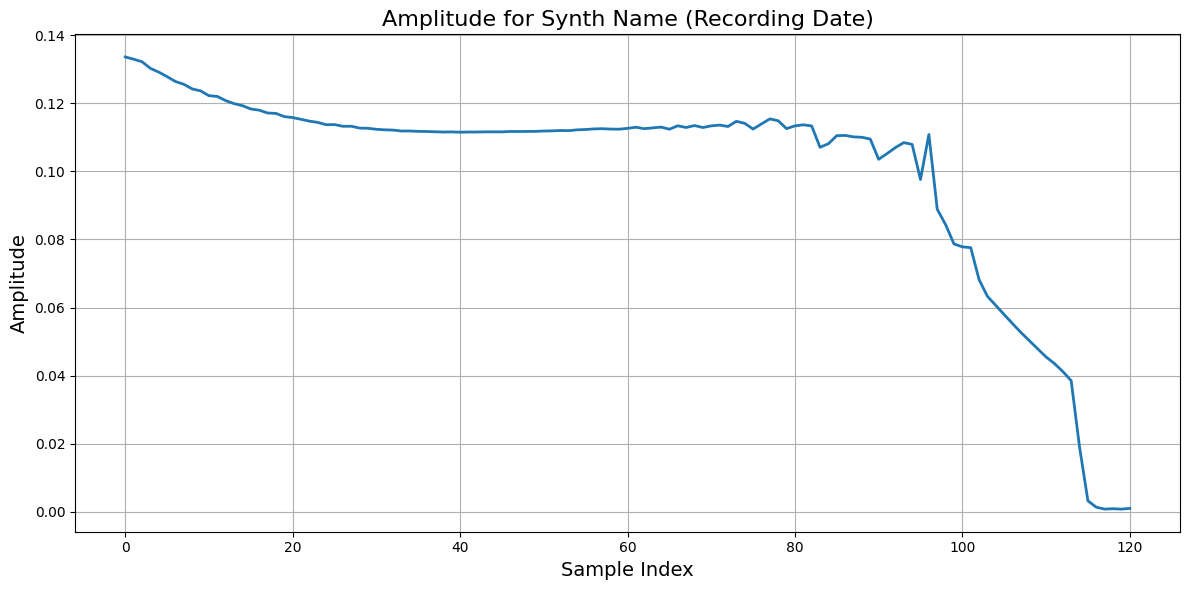

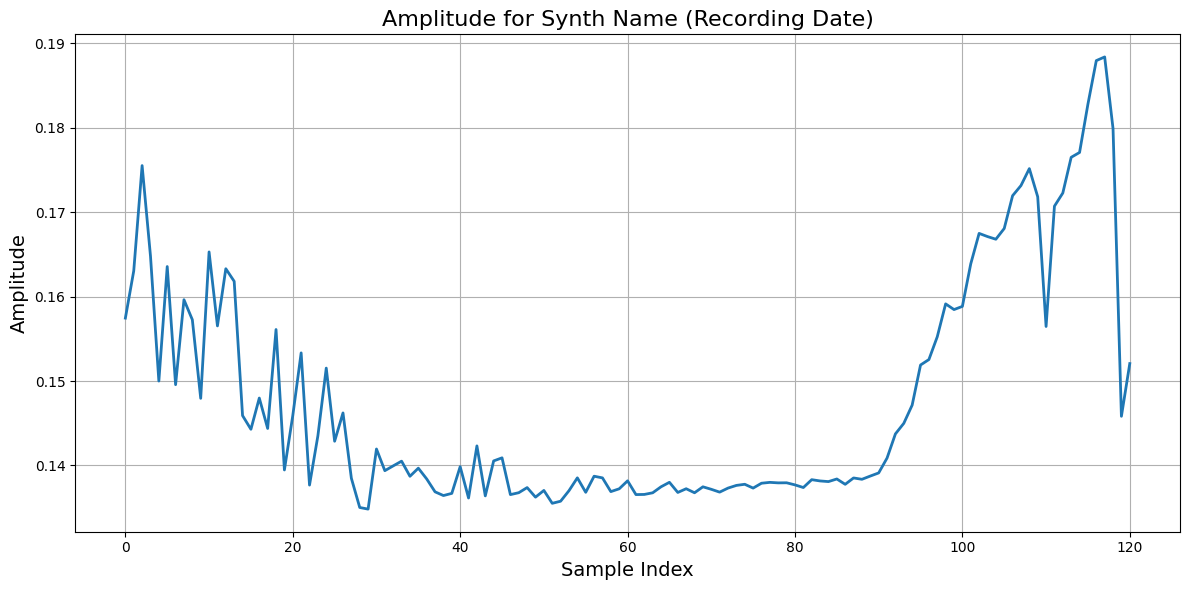

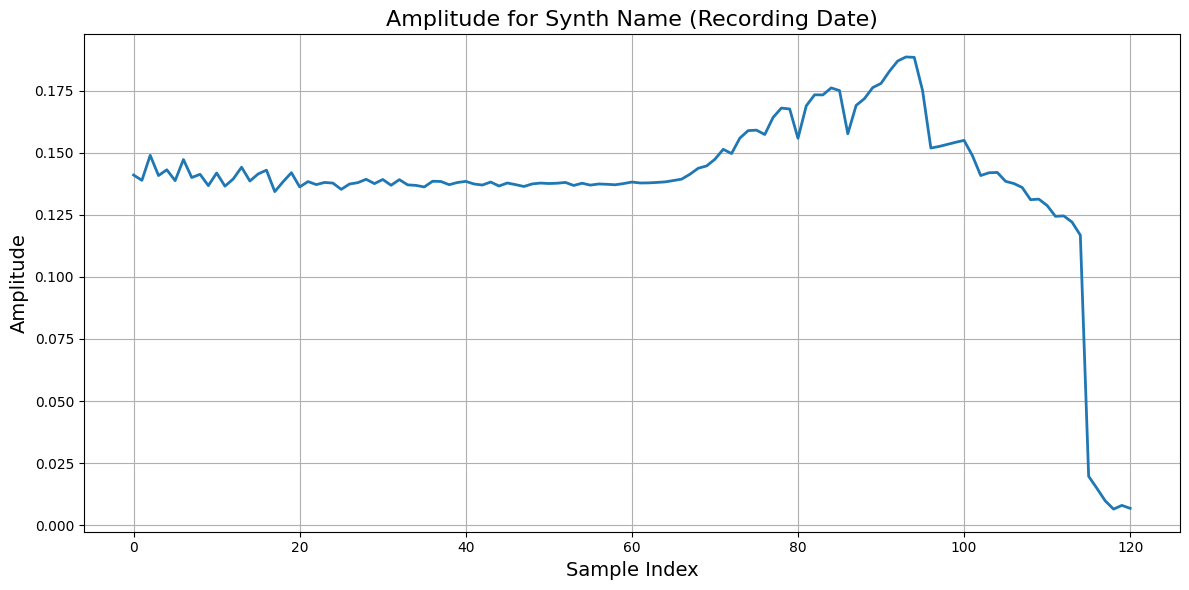

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the folder containing CSV files
folder_path = "/content/drive/MyDrive/Bakalauras/Pitch_amplitude"

def read_vco_data(file_path):
    """
    Read VCO data from a CSV file.

    Returns:
    - vco_name: Name of the VCO
    - measurement_date: Date of measurement
    - frequency_data: List of frequency values
    - amplitude_data: List of amplitude values
    """
    # Read the first two lines to get VCO name and measurement date
    with open(file_path, 'r') as f:
        vco_name = f.readline().split(',')[0].strip()
        measurement_date = f.readline().split(',')[0].strip()

    # Read the rest of the file as CSV, skipping the first two rows
    # The third row contains column headers
    data = pd.read_csv(file_path, skiprows=2)

    # Extract frequency (2nd column) and amplitude (4th column) data
    # Note: Using iloc for positional indexing (0-based)
    frequency_data = data.iloc[:, 1]  # 2nd column
    amplitude_data = data.iloc[:, 3]  # 4th column

    return vco_name, measurement_date, frequency_data.values, amplitude_data.values

def analyze_and_plot_vco_data():
    """
    Read all CSV files in the folder and plot frequency and amplitude data.
    """
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {folder_path}")
        return

    # Create a figure for frequency comparison
    plt.figure(figsize=(14, 8))

    # Store all VCO data for later use
    all_vco_data = []

    # Process each CSV file
    for file_path in csv_files:
        file_name = os.path.basename(file_path)
        try:
            vco_name, measurement_date, frequency_data, amplitude_data = read_vco_data(file_path)
            all_vco_data.append({
                'file_name': file_name,
                'vco_name': vco_name,
                'measurement_date': measurement_date,
                'frequency_data': frequency_data,
                'amplitude_data': amplitude_data
            })

            # Plot frequency data (all on the same graph)
            plt.plot(frequency_data, label=f"{vco_name} ({measurement_date})")

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Finalize frequency plot
    plt.title("VCO Frequency Comparison", fontsize=16)
    plt.xlabel("Sample Index", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    # Save the frequency plot
    plt.savefig(os.path.join(folder_path, "frequency_comparison.png"), dpi=300)
    plt.show()

    # Plot all amplitude data on one graph for comparison
    plt.figure(figsize=(14, 8))
    for vco_data in all_vco_data:
        plt.plot(vco_data['amplitude_data'],
                 label=f"{vco_data['vco_name']} ({vco_data['measurement_date']})")

    # Finalize amplitude comparison plot
    plt.title("VCO Amplitude Comparison", fontsize=16)
    plt.xlabel("Sample Index", fontsize=14)
    plt.ylabel("Amplitude", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    # Save the amplitude comparison plot
    plt.savefig(os.path.join(folder_path, "amplitude_comparison.png"), dpi=300)
    plt.show()

    # Now create individual amplitude plots for each VCO
    for vco_data in all_vco_data:
        plt.figure(figsize=(12, 6))
        plt.plot(vco_data['amplitude_data'], linewidth=2)
        plt.title(f"Amplitude for {vco_data['vco_name']} ({vco_data['measurement_date']})", fontsize=16)
        plt.xlabel("Sample Index", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.grid(True)
        plt.tight_layout()

        # Save individual amplitude plots
        clean_name = vco_data['vco_name'].replace(" ", "_").replace("/", "_")
        plt.savefig(os.path.join(folder_path, f"amplitude_{clean_name}.png"), dpi=300)
        plt.show()

# Run the analysis and plotting function
analyze_and_plot_vco_data()

In [ ]:
# @title
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the directory path
directory = "/content/drive/MyDrive/Bakalauras/Pitch_amplitude"

def get_theoretical_frequency(note_idx):
    """Calculate theoretical frequency for a note index where 0 = C0, 1 = C#0, ..."""
    # A4 is 69th key on piano (index 57 if we start from C0 as 0)
    # A4 frequency is 440 Hz
    a4_idx = 57
    a4_freq = 440.0

    # Calculate using the formula: f = 440 * 2^((n-57)/12)
    return a4_freq * (2 ** ((note_idx - a4_idx) / 12.0))

def note_index_to_name(note_idx):
    """Convert note index to note name (C0 = 0, C#0 = 1, etc.)"""
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = note_idx // 12
    note = notes[note_idx % 12]
    return f"{note}{octave}"

def frequency_to_note_index(freq):
    """Convert frequency to closest note index"""
    # A4 = 440 Hz, index 57 (if C0 = 0)
    a4_idx = 57
    a4_freq = 440.0

    # Calculate note index
    if freq > 0:
        note_idx = round(12 * np.log2(freq / a4_freq) + a4_idx)
        return note_idx
    return -1  # Invalid frequency

def read_csv_file(file_path):
    """Read and process a CSV file according to the specified format"""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Extract VCO name from first row
    first_row = lines[0].strip().split(',')
    vco_name = first_row[1] if len(first_row) > 1 else "Unknown VCO"

    # Extract measurement date from second row
    second_row = lines[1].strip().split(',')
    date = second_row[1] if len(second_row) > 1 else "Unknown Date"

    # Create a DataFrame starting from the fourth row (data)
    data_lines = [line.strip() for line in lines[3:]]
    data_rows = [line.split(',') for line in data_lines if line]

    # Create DataFrame
    if data_rows:
        df = pd.DataFrame(data_rows)
        if len(df.columns) >= 5:  # Ensure we have at least 5 columns
            # Keep only columns 2 (frequency) and 4 (amplitude)
            df = df.iloc[:, [1, 3]]
            df.columns = ['Frequency', 'Amplitude']

            # Convert to numeric
            df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')
            df['Amplitude'] = pd.to_numeric(df['Amplitude'], errors='coerce')

            # Drop rows with NaN values
            df = df.dropna()

            # Calculate note index
            df['Note_Index'] = df['Frequency'].apply(frequency_to_note_index)

            # Calculate theoretical frequency
            df['Theoretical_Frequency'] = df['Note_Index'].apply(get_theoretical_frequency)

            # Calculate frequency deviation
            df['Frequency_Deviation'] = df['Frequency'] - df['Theoretical_Frequency']

            return df, vco_name, date

    return pd.DataFrame(), "Error", "Error"

# Get list of CSV files
csv_files = glob.glob(os.path.join(directory, '*.csv'))

if not csv_files:
    print(f"No CSV files found in {directory}")
else:
    # Process each file
    all_data = []

    for file_path in csv_files:
        df, vco_name, date = read_csv_file(file_path)
        if not df.empty:
            # Filter out data points outside C0-C9 range (0-108)
            df = df[(df['Note_Index'] >= 0) & (df['Note_Index'] <= 108)]

            if not df.empty:
                all_data.append({
                    'df': df,
                    'vco_name': vco_name,
                    'date': date,
                    'file': os.path.basename(file_path)
                })

    if all_data:
        # Create frequency deviation plot (all files on the same plot)
        plt.figure(figsize=(15, 8))

        # Create X tick positions and labels (C notes)
        c_indices = [i*12 for i in range(10)]  # C0 to C9
        c_labels = [f"C{i}" for i in range(10)]

        # Create Y tick positions for A notes
        a_freqs = [27.5 * (2**i) for i in range(8)]  # A0 to A7

        for data in all_data:
            df = data['df']
            label = f"{data['vco_name']} ({data['date']})"

            plt.plot(df['Note_Index'], df['Frequency_Deviation'], '--', label=label)

        plt.grid(True)
        plt.xticks(c_indices, c_labels)
        plt.yticks(a_freqs, [f"A{i}: {freq:.1f}Hz" for i, freq in enumerate(a_freqs)])
        plt.xlabel('Note')
        plt.ylabel('Frequency Deviation (Hz)')
        plt.title('VCO Frequency Deviation from Theoretical Values')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(directory, 'frequency_deviation_plot.png'))
        plt.show()

        # Create amplitude plots
        plt.figure(figsize=(15, 8))

        for data in all_data:
            df = data['df']
            label = f"{data['vco_name']} ({data['date']})"

            plt.plot(df['Note_Index'], df['Amplitude'], '--', label=label)

        plt.grid(True)
        plt.xticks(c_indices, c_labels)
        plt.xlabel('Note')
        plt.ylabel('Amplitude')
        plt.title('VCO Amplitude vs Note')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(directory, 'amplitude_plot.png'))
        plt.show()

        print(f"Processed {len(all_data)} files and created plots")
        print(f"Plots saved to {directory}")
    else:
        print("No valid data found in the CSV files")

# VCO Analysis Tool with Enhanced Amplitude Display and Default Smoothing

HTML(value='<h2>VCO Analysis Controls</h2>')

HTML(value='<h3>Graph Selection</h3>')

HTML(value='<h3>Chart Display Controls</h3>')

HTML(value='<h3>Scaling and Smoothing</h3>')

HTML(value='<h3>Graph Titles and Axis Labels</h3>')

Text(value='Dažnio-amplitudės priklausomybė', description='Amplitude Title:', layout=Layout(width='400px'), pl…

Text(value='Dažnio nuokrypis nuo teorinio', description='Deviation Title:', layout=Layout(width='400px'), plac…

HTML(value='<h3>VCO Selection and Custom Names</h3>')

<ipython-input-1-ee0edba3a483>:550: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(colormap_dropdown.value)


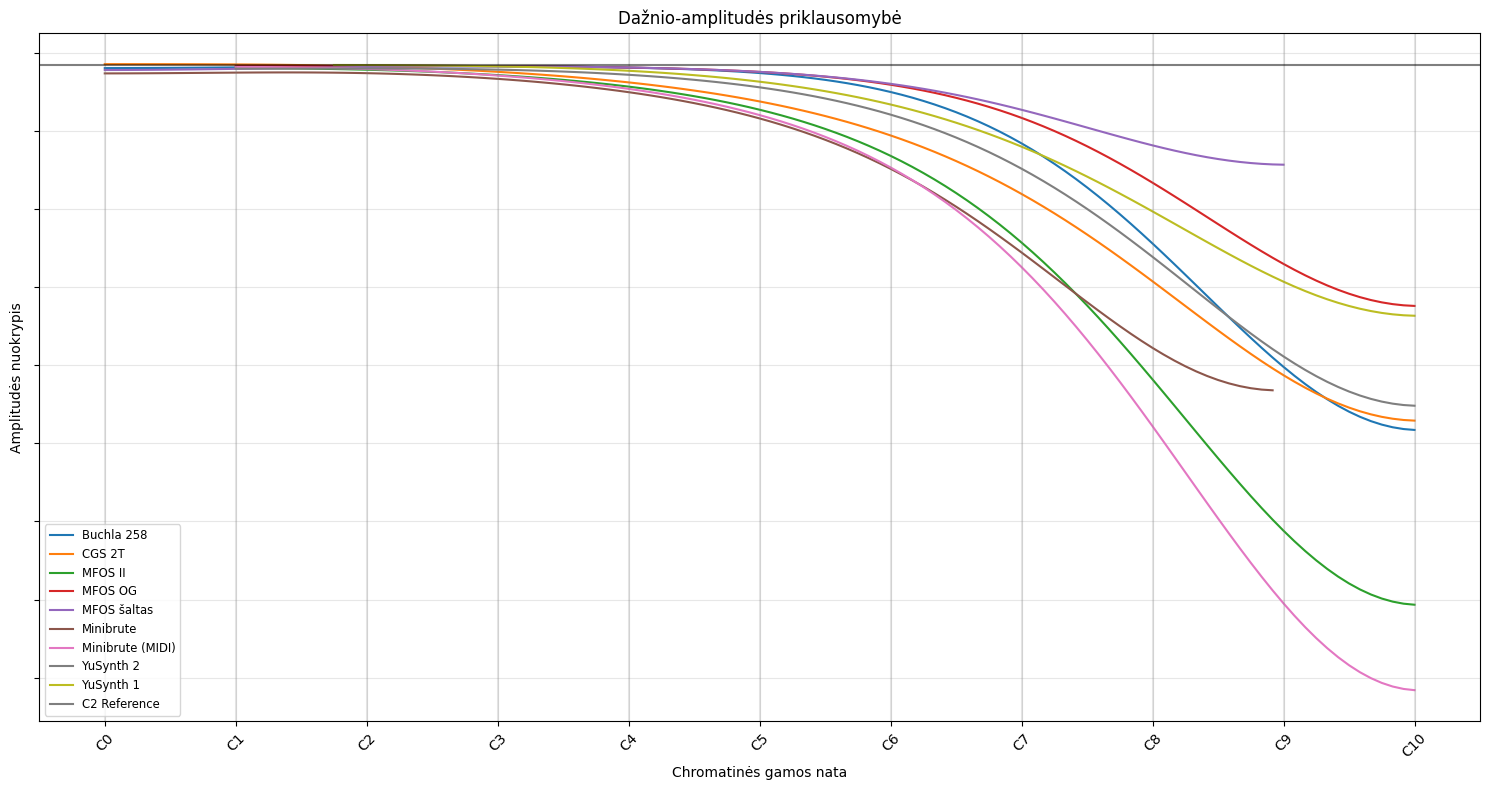

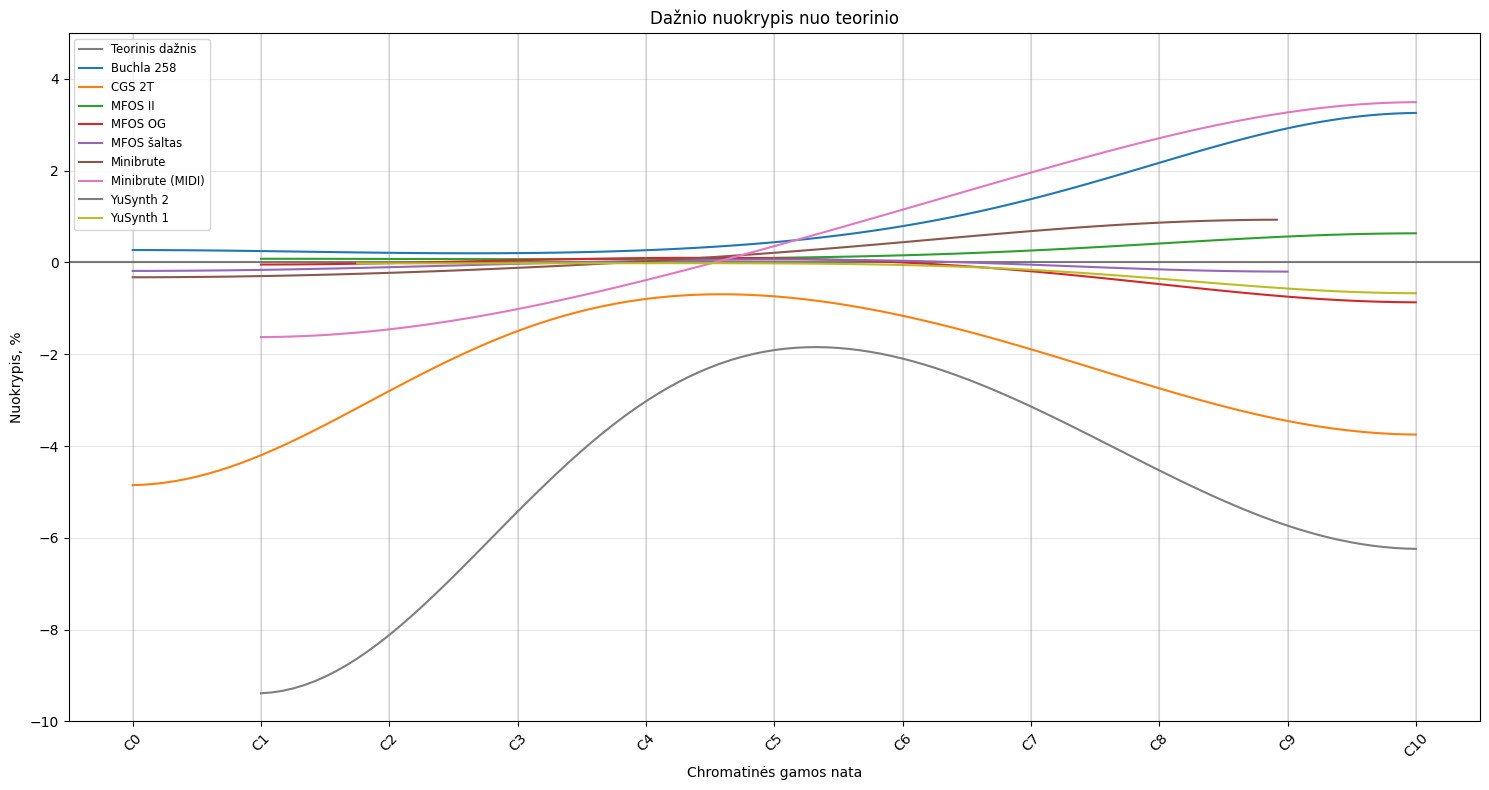

In [1]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.scale import SymmetricalLogScale
from scipy.ndimage import gaussian_filter1d
from google.colab import drive
from google.colab import auth
import gspread
from google.auth import default
import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Print script execution info
print(f"Current Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-03-26 18:25:30")
print(f"Current User's Login: eigulys")

# Mount Google Drive
drive.mount('/content/drive')

# Authenticate for Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the spreadsheet using the direct URL
sheet_url = "https://docs.google.com/spreadsheets/d/18300maI5_fXYvME8fee4XsR1n7c5FGy_3J8HEQLOXOQ/edit?gid=722793454#gid=722793454"
sh = gc.open_by_url(sheet_url)
print(f"Successfully opened sheet: {sh.title}")

# Get the first worksheet
worksheet = sh.get_worksheet(0)
values = worksheet.get_all_values()
print(f"Retrieved {len(values)} rows of data")

# Find the last row (where first column is "C10")
last_row = 0
for i, row in enumerate(values):
    if row[0] == "C10":
        last_row = i
        break
print(f"Last row index: {last_row}")

# Get note names for X-axis from column A (first column)
note_names = [values[i][0] for i in range(2, last_row + 1) if i < len(values)]
print(f"Note names from column A (first 5): {note_names[:5]}...")

# Get theoretical frequencies from column B if available
theo_freq = []
for i in range(2, last_row + 1):
    if i < len(values) and len(values[i]) > 1 and values[i][1]:
        try:
            theo_freq.append(float(values[i][1].replace(',', '.')))
        except ValueError:
            theo_freq.append(None)
    else:
        theo_freq.append(None)

# Identify which note names are C notes (without the # sign)
c_notes_indices = [i for i, note in enumerate(note_names) if note.startswith('C') and '#' not in note]
c_notes = [note_names[i] for i in c_notes_indices]
print(f"C notes for grid: {c_notes}")

# Find the index of C2 for amplitude alignment
try:
    c2_index = note_names.index("C2")
    print(f"Found C2 at index {c2_index}")
except ValueError:
    # If C2 is not found, use the third C note (or first if not enough)
    if len(c_notes_indices) >= 3:
        c2_index = c_notes_indices[2]
    else:
        c2_index = c_notes_indices[0] if c_notes_indices else 0
    print(f"C2 not explicitly found, using index {c2_index} instead")

# Initialize frequency and amplitude data structures
freq_data = {}  # {vco_name: [freq_values...]}
amp_data = {}   # {vco_name: [amp_values...]}

# Process each column starting from column C (index 2)
col_idx = 2
while col_idx < len(values[1]):  # Use row 2 (column types) to determine end
    # Check if we've reached the end of data
    if col_idx >= len(values[1]) or not values[1][col_idx]:
        break

    # Get column type and VCO name
    col_type = values[1][col_idx].strip().lower()
    vco_name = values[0][col_idx] if col_idx < len(values[0]) else ""

    print(f"Column {col_idx}: Type={col_type}, VCO={vco_name}")

    # Skip column if it doesn't have a valid type or VCO name
    if not vco_name or not col_type:
        col_idx += 1
        continue

    # Process based on column type
    if col_type == "freq":
        # Initialize array for this VCO if not already done
        if vco_name not in freq_data:
            freq_data[vco_name] = [None] * len(note_names)

        # Extract frequency data
        for i in range(len(note_names)):
            row_idx = i + 2  # Data starts at row 3 (index 2)
            if row_idx < len(values) and col_idx < len(values[row_idx]) and values[row_idx][col_idx]:
                try:
                    freq_data[vco_name][i] = float(values[row_idx][col_idx].replace(',', '.'))
                except ValueError:
                    pass  # Keep as None if conversion fails

    elif col_type == "amp":
        # Initialize array for this VCO if not already done
        if vco_name not in amp_data:
            amp_data[vco_name] = [None] * len(note_names)

        # Extract amplitude data
        for i in range(len(note_names)):
            row_idx = i + 2  # Data starts at row 3 (index 2)
            if row_idx < len(values) and col_idx < len(values[row_idx]) and values[row_idx][col_idx]:
                try:
                    amp_data[vco_name][i] = float(values[row_idx][col_idx].replace(',', '.'))
                except ValueError:
                    pass  # Keep as None if conversion fails

    # Move to next column
    col_idx += 1

# Report data collection results
print(f"Collected frequency data for {len(freq_data)} VCOs: {', '.join(freq_data.keys())}")
print(f"Collected amplitude data for {len(amp_data)} VCOs: {', '.join(amp_data.keys())}")

# Generate A note frequencies for the grid (Y-axis)
a_freq = 27.5
a_freqs = [a_freq * (2**i) for i in range(10)]

# Get all unique VCO names
all_vco_names = sorted(set(list(freq_data.keys()) + list(amp_data.keys())))

# Create widgets for interactive plotting
style_options = ['solid', 'dashed', 'dotted', 'dashdot']
marker_options = ['None', 'o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']
colormap_options = ['tab10', 'Set1', 'Dark2', 'viridis', 'plasma', 'inferno', 'magma', 'cividis']
graph_type_options = ['line', 'scatter', 'line+marker']

# Scale options for deviation graph
scale_options = [
    ('Linear', 'linear'),
    ('Logarithmic', 'log'),
    ('Symmetric Log', 'symlog'),
    ('Square Root', 'sqrt')
]

# Create widgets
line_style_dropdown = widgets.Dropdown(
    options=style_options,
    value='solid',
    description='Line Style:',
    disabled=False,
    layout=widgets.Layout(width='180px')
)

marker_style_dropdown = widgets.Dropdown(
    options=marker_options,
    value='None',
    description='Marker:',
    disabled=False,
    layout=widgets.Layout(width='180px')
)

colormap_dropdown = widgets.Dropdown(
    options=colormap_options,
    value='tab10',
    description='Color Map:',
    disabled=False,
    layout=widgets.Layout(width='180px')
)

graph_type_dropdown = widgets.Dropdown(
    options=graph_type_options,
    value='line',
    description='Graph Type:',
    disabled=False,
    layout=widgets.Layout(width='180px')
)

# Add checkbox for logarithmic y-axis scale in frequency graph
freq_log_scale_checkbox = widgets.Checkbox(
    value=True,  # Default to logarithmic scale
    description='Logarithmic Y-axis (Frequency)',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

# Add scale dropdown for deviation graph Y-axis
dev_scale_dropdown = widgets.Dropdown(
    options=scale_options,
    value='linear',
    description='Deviation Y-axis Scale:',
    disabled=False,
    layout=widgets.Layout(width='250px')
)

# Add Y-axis range controls for deviation graph
dev_y_min_input = widgets.FloatText(
    value=-5.0,
    description='Y-Axis Min:',
    disabled=False,
    layout=widgets.Layout(width='150px')
)

dev_y_max_input = widgets.FloatText(
    value=5.0,
    description='Y-Axis Max:',
    disabled=False,
    layout=widgets.Layout(width='150px')
)

dev_auto_y_scale_checkbox = widgets.Checkbox(
    value=True,
    description='Auto Y-Axis Scale',
    disabled=False,
    layout=widgets.Layout(width='180px'),
    style={'description_width': 'initial'}
)

# Add checkbox to show units on amplitude Y-axis
show_amp_y_labels_checkbox = widgets.Checkbox(
    value=False,  # Default to hide
    description='Show Amplitude Y-Axis Values',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

# Add checkbox for amplitude percentage display
amp_percentage_checkbox = widgets.Checkbox(
    value=False,  # Default to absolute values
    description='Show Amplitude as Percentage',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

# Add checkboxes for showing/hiding graphs
show_freq_graph_checkbox = widgets.Checkbox(
    value=False,  # Default to hidden
    description='Show Frequency Graph',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

show_amp_graph_checkbox = widgets.Checkbox(
    value=True,  # Default to visible
    description='Show Amplitude Graph',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

show_dev_graph_checkbox = widgets.Checkbox(
    value=True,  # Default to visible
    description='Show Deviation Graph',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

# Add Gaussian smoothing slider for amplitude graph - updated default value to 15
amp_gaussian_sigma_slider = widgets.FloatSlider(
    value=15.0,  # Default set to 15 as requested
    min=0,
    max=30,
    step=0.5,
    description='Amp Smoothing:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='400px')
)

# Add Gaussian smoothing slider for deviation graph - updated default value to 20
dev_gaussian_sigma_slider = widgets.FloatSlider(
    value=20.0,  # Default set to 20 as requested
    min=0,
    max=30,
    step=0.5,
    description='Dev Smoothing:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='400px')
)

# Add checkbox for deviation Y-axis unit (percentage or Hz)
dev_unit_percentage_checkbox = widgets.Checkbox(
    value=True,  # Default to percentage
    description='Use Percentage for Deviation (uncheck for Hz)',
    disabled=False,
    layout=widgets.Layout(width='350px'),
    style={'description_width': 'initial'}
)

# Create a unified set of VCO checkboxes and custom name inputs
vco_checkboxes = {}
vco_name_inputs = {}

for vco in all_vco_names:
    vco_checkboxes[vco] = widgets.Checkbox(
        value=True,
        description=vco,
        disabled=False,
        layout=widgets.Layout(width='auto'),
        style={'description_width': 'initial'}
    )

    vco_name_inputs[vco] = widgets.Text(
        value=vco,  # Default to original name
        placeholder='Custom name',
        description='',
        disabled=False,
        layout=widgets.Layout(width='150px')
    )

# Toggle for theoretical frequency curve
theo_freq_checkbox = widgets.Checkbox(
    value=True,
    description='Show Theoretical Frequency',
    disabled=False,
    layout=widgets.Layout(width='250px'),
    style={'description_width': 'initial'}
)

theo_freq_name_input = widgets.Text(
    value='Teorinis',  # Default name in Lithuanian
    placeholder='Custom name for theoretical curve',
    description='',
    disabled=False,
    layout=widgets.Layout(width='150px')
)

# Graph title and axis label customization (including new deviation graph)
freq_graph_title_input = widgets.Text(
    value='Chromatinių intervalų atkūrimas',
    placeholder='Frequency graph title',
    description='Frequency Title:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

freq_x_axis_label_input = widgets.Text(
    value='Chromatinės gamos nata',
    placeholder='Frequency x-axis label',
    description='Freq X-axis:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

freq_y_axis_label_input = widgets.Text(
    value='Dažnis, Hz',
    placeholder='Frequency y-axis label',
    description='Freq Y-axis:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

amp_graph_title_input = widgets.Text(
    value='Dažnio-amplitudės priklausomybė',
    placeholder='Amplitude graph title',
    description='Amplitude Title:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

amp_x_axis_label_input = widgets.Text(
    value='Chromatinės gamos nata',
    placeholder='Amplitude x-axis label',
    description='Amp X-axis:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

amp_y_axis_label_input = widgets.Text(
    value='Amplitudės nuokrypis',
    placeholder='Amplitude y-axis label',
    description='Amp Y-axis:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

# New fields for the deviation graph
dev_graph_title_input = widgets.Text(
    value='Dažnio nuokrypis nuo teorinio',
    placeholder='Deviation graph title',
    description='Deviation Title:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

dev_x_axis_label_input = widgets.Text(
    value='Chromatinės gamos nata',
    placeholder='Deviation x-axis label',
    description='Dev X-axis:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

dev_y_axis_label_input = widgets.Text(
    value='Nuokrypis, %',
    placeholder='Deviation y-axis label',
    description='Dev Y-axis:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

# Function to apply Gaussian smoothing to array with handling of None values
def smooth_array(arr, sigma):
    if sigma <= 0:
        return arr

    # Extract non-None values and their indices
    valid_indices = []
    valid_values = []
    for i, val in enumerate(arr):
        if val is not None:
            valid_indices.append(i)
            valid_values.append(val)

    if not valid_values:
        return arr  # Return original if no valid values

    # Apply Gaussian smoothing to valid values
    smoothed_values = gaussian_filter1d(valid_values, sigma)

    # Create new array with smoothed values at original positions
    result = [None] * len(arr)
    for i, val in enumerate(smoothed_values):
        result[valid_indices[i]] = val

    return result

# Function to update the plots based on selections
def update_plots(b=None):
    # Clear previous output
    clear_output(wait=True)

    # Display controls
    display(widgets.HTML('<h2>VCO Analysis Controls</h2>'))

    # Graph selection controls
    display(widgets.HTML('<h3>Graph Selection</h3>'))
    display(widgets.HBox([show_freq_graph_checkbox, show_amp_graph_checkbox, show_dev_graph_checkbox]))

    # Graph appearance controls
    display(widgets.HTML('<h3>Chart Display Controls</h3>'))
    display(widgets.HBox([graph_type_dropdown, line_style_dropdown, marker_style_dropdown, colormap_dropdown]))

    # Scale controls
    display(widgets.HTML('<h3>Scaling and Smoothing</h3>'))

    # Show appropriate controls based on which graphs are enabled
    scale_controls = []
    if show_freq_graph_checkbox.value:
        scale_controls.append(freq_log_scale_checkbox)

    if show_amp_graph_checkbox.value:
        # Add both amplitude display controls
        scale_controls.extend([show_amp_y_labels_checkbox, amp_percentage_checkbox])

    if show_dev_graph_checkbox.value:
        scale_controls.extend([dev_unit_percentage_checkbox, dev_scale_dropdown])

    if scale_controls:
        display(widgets.HBox(scale_controls))

    # Y-axis range controls for deviation graph
    if show_dev_graph_checkbox.value:
        display(widgets.HBox([
            dev_auto_y_scale_checkbox,
            dev_y_min_input,
            dev_y_max_input
        ]))

    # Smoothing sliders
    smoothing_controls = []
    if show_amp_graph_checkbox.value:
        smoothing_controls.append(amp_gaussian_sigma_slider)

    if show_dev_graph_checkbox.value:
        smoothing_controls.append(dev_gaussian_sigma_slider)

    if smoothing_controls:
        display(widgets.VBox(smoothing_controls))

    # Graph title and axis labels
    display(widgets.HTML('<h3>Graph Titles and Axis Labels</h3>'))

    if show_freq_graph_checkbox.value:
        display(freq_graph_title_input)
        display(widgets.HBox([freq_x_axis_label_input, freq_y_axis_label_input]))

    if show_amp_graph_checkbox.value:
        display(amp_graph_title_input)
        display(widgets.HBox([amp_x_axis_label_input, amp_y_axis_label_input]))

    if show_dev_graph_checkbox.value:
        display(dev_graph_title_input)
        display(widgets.HBox([dev_x_axis_label_input, dev_y_axis_label_input]))

    # VCO selection and naming
    display(widgets.HTML('<h3>VCO Selection and Custom Names</h3>'))
    display(widgets.HBox([
        widgets.Label('Selection'),
        widgets.Label('Original Name'),
        widgets.Label('Custom Display Name')
    ]))

    # Theoretical frequency curve
    display(widgets.HBox([
        theo_freq_checkbox,
        widgets.Label('Theoretical'),
        theo_freq_name_input
    ]))

    # Display VCOs with checkboxes and name inputs
    for vco in all_vco_names:
        display(widgets.HBox([
            vco_checkboxes[vco],
            widgets.Label(vco, layout=widgets.Layout(width='150px')),
            vco_name_inputs[vco]
        ]))

    # Update button
    display(widgets.HBox([plot_button],
                        layout=widgets.Layout(justify_content='center',
                                             margin='20px 0px')))

    # Get selected options
    line_style = line_style_dropdown.value
    marker_style = None if marker_style_dropdown.value == 'None' else marker_style_dropdown.value
    colormap = plt.cm.get_cmap(colormap_dropdown.value)
    graph_type = graph_type_dropdown.value
    freq_log_scale = freq_log_scale_checkbox.value
    dev_scale = dev_scale_dropdown.value
    amp_sigma = amp_gaussian_sigma_slider.value
    dev_sigma = dev_gaussian_sigma_slider.value
    dev_use_percentage = dev_unit_percentage_checkbox.value
    show_amp_y_labels = show_amp_y_labels_checkbox.value
    amp_as_percentage = amp_percentage_checkbox.value

    # Get Y-axis range settings for deviation graph
    auto_y_scale = dev_auto_y_scale_checkbox.value
    dev_y_min = dev_y_min_input.value
    dev_y_max = dev_y_max_input.value

    # Get custom names for VCOs (create a mapping)
    vco_display_names = {vco: vco_name_inputs[vco].value for vco in all_vco_names}
    theo_display_name = theo_freq_name_input.value

    # Get graph titles and axis labels
    freq_graph_title = freq_graph_title_input.value
    freq_x_axis_label = freq_x_axis_label_input.value
    freq_y_axis_label = freq_y_axis_label_input.value
    amp_graph_title = amp_graph_title_input.value
    amp_x_axis_label = amp_x_axis_label_input.value
    amp_y_axis_label = amp_y_axis_label_input.value

    # Update amplitude Y-axis label if showing as percentage
    if amp_as_percentage and not 'nuokrypis, %' in amp_y_axis_label.lower():
        original_amp_label = amp_y_axis_label
        amp_y_axis_label = 'Amplitudės nuokrypis, %'

    dev_graph_title = dev_graph_title_input.value
    dev_x_axis_label = dev_x_axis_label_input.value
    dev_y_axis_label = dev_y_axis_label_input.value

    # Adjust deviation Y-axis label based on unit selection
    if not dev_use_percentage and 'Nuokrypis, %' in dev_y_axis_label:
        dev_y_axis_label = 'Nuokrypis, Hz'
    elif dev_use_percentage and 'Nuokrypis, Hz' in dev_y_axis_label:
        dev_y_axis_label = 'Nuokrypis, %'

    # Get selected VCOs
    selected_vcos = [vco for vco, checkbox in vco_checkboxes.items() if checkbox.value]

    # -------------------------------------------------------------------------
    # Plot frequency graph (if enabled)
    # -------------------------------------------------------------------------
    if show_freq_graph_checkbox.value:
        plt.figure(figsize=(15, 8))

        # Plot theoretical frequency if checked
        if theo_freq_checkbox.value:
            valid_theo_indices = [i for i, val in enumerate(theo_freq) if val is not None]
            if valid_theo_indices:
                x_positions = valid_theo_indices
                y_theo = [theo_freq[i] for i in valid_theo_indices]
                plt.plot(x_positions, y_theo, linestyle='--',
                         color='grey', linewidth=0.8, label=theo_display_name, alpha=0.7)

        # Plot frequency data for selected VCOs
        for i, vco in enumerate(selected_vcos):
            if vco in freq_data:
                color = colormap(i % colormap.N)

                # Get display name for the VCO
                display_name = vco_display_names[vco]

                # Filter out None values
                valid_freq_indices = [i for i, val in enumerate(freq_data[vco]) if val is not None]
                if valid_freq_indices:
                    x_positions = valid_freq_indices
                    y_freq = [freq_data[vco][i] for i in valid_freq_indices]

                    # Apply selected plot type
                    if graph_type == 'line':
                        plt.plot(x_positions, y_freq, linestyle=line_style, color=color, label=display_name)
                    elif graph_type == 'scatter':
                        plt.scatter(x_positions, y_freq, marker=marker_style, color=color, label=display_name)
                    else:  # line+marker
                        plt.plot(x_positions, y_freq, marker=marker_style, linestyle=line_style,
                                 color=color, label=display_name)

        # Set custom labels and title
        plt.xlabel(freq_x_axis_label)
        plt.ylabel(freq_y_axis_label)
        plt.title(freq_graph_title)
        plt.grid(True, alpha=0.3)

        # Set x-ticks to show only C notes without #
        plt.xticks(c_notes_indices, c_notes, rotation=45)

        # Add vertical grid lines for C notes
        for pos in c_notes_indices:
            plt.axvline(x=pos, color='gray', linestyle='-', alpha=0.2)

        # Set y-axis scale based on checkbox
        if freq_log_scale:
            plt.yscale('log')
            # Set y-axis grid to A note theoretical frequencies
            plt.gca().yaxis.set_major_locator(ticker.FixedLocator(a_freqs))
            plt.gca().yaxis.grid(True)
            plt.gca().set_yticks(a_freqs)
            plt.gca().set_yticklabels([f"A: {freq:.1f}Hz" for freq in a_freqs])
        else:
            plt.yscale('linear')
            plt.gca().yaxis.grid(True)

        plt.legend(loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------------------------
    # Plot amplitude graph (if enabled) with smoothing and percentage option
    # -------------------------------------------------------------------------
    if show_amp_graph_checkbox.value:
        plt.figure(figsize=(15, 8))

        # Find reference amplitude value at C2 for offset calculation
        reference_value = None
        amp_at_c2 = {}

        # Get amplitude values at C2 for VCOs that have amplitude data
        for vco in selected_vcos:
            if vco not in amp_data:
                continue

            if c2_index < len(amp_data[vco]) and amp_data[vco][c2_index] is not None:
                amp_at_c2[vco] = amp_data[vco][c2_index]
                if reference_value is None:
                    reference_value = amp_at_c2[vco]

        # If no valid reference found, use 0
        if reference_value is None:
            reference_value = 0

        # Plot amplitude data for each selected VCO
        for i, vco in enumerate(selected_vcos):
            if vco not in amp_data:
                continue

            color = colormap(i % colormap.N)

            # Get display name for the VCO
            display_name = vco_display_names[vco]

            # Filter out None values for amplitude
            valid_indices = [i for i, val in enumerate(amp_data[vco]) if val is not None]
            if valid_indices:
                x_positions = valid_indices
                y_amp = [amp_data[vco][i] for i in valid_indices]

                # Calculate offset to align at C2
                offset = 0
                if vco in amp_at_c2:
                    offset = reference_value - amp_at_c2[vco]

                # Apply offset
                y_amp_offset = [val + offset for val in y_amp]

                # Convert to percentage if requested
                if amp_as_percentage:
                    # Calculate percentage deviation from reference
                    if reference_value != 0:  # Avoid division by zero
                        y_amp_offset = [(val - reference_value) / abs(reference_value) * 100 for val in y_amp_offset]
                    else:
                        # If reference is zero, just use actual values as is
                        y_amp_offset = [val * 100 for val in y_amp_offset]

                # Apply Gaussian smoothing if requested
                if amp_sigma > 0:
                    y_amp_offset = smooth_array(y_amp_offset, amp_sigma)

                # Apply selected plot type
                if graph_type == 'line':
                    plt.plot(x_positions, y_amp_offset, linestyle=line_style, color=color, label=display_name)
                elif graph_type == 'scatter':
                    plt.scatter(x_positions, y_amp_offset, marker=marker_style, color=color, label=display_name)
                else:  # line+marker
                    plt.plot(x_positions, y_amp_offset, marker=marker_style, linestyle=line_style,
                             color=color, label=display_name)

        # Set custom labels and title
        plt.xlabel(amp_x_axis_label)
        plt.ylabel(amp_y_axis_label)
        plt.title(amp_graph_title)
        plt.grid(True, alpha=0.3)

        # Set x-ticks to show only C notes
        plt.xticks(c_notes_indices, c_notes, rotation=45)

        # Add vertical grid lines for C notes
        for pos in c_notes_indices:
            plt.axvline(x=pos, color='gray', linestyle='-', alpha=0.2)

        # Use linear y-axis for amplitude graph
        plt.yscale('linear')

        # Show or hide y-axis labels based on checkbox
        if not show_amp_y_labels:
            plt.gca().set_yticklabels([])

        # Add horizontal line at reference value
        if amp_as_percentage:
            # If showing as percentage, reference line is at 0%
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='C2 Reference (0%)')
        else:
            # If showing absolute values, reference line is at reference_value
            plt.axhline(y=reference_value, color='black', linestyle='-', alpha=0.5, label='C2 Reference')

        # Move legend to lower left corner
        plt.legend(loc='lower left', fontsize='small')
        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------------------------
    # Plot frequency deviation from theoretical (if enabled)
    # -------------------------------------------------------------------------
    if show_dev_graph_checkbox.value:
        plt.figure(figsize=(15, 8))

        # Plot horizontal reference line at 0% deviation
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Teorinis dažnis')

        # Calculate min/max deviation values for auto-scaling
        all_deviation_values = []

        # Plot deviation data for each selected VCO
        for i, vco in enumerate(selected_vcos):
            if vco in freq_data:
                color = colormap(i % colormap.N)

                # Get display name for the VCO
                display_name = vco_display_names[vco]

                # Calculate deviation from theoretical frequency
                deviation_data = []
                deviation_indices = []

                for j, freq_val in enumerate(freq_data[vco]):
                    if freq_val is not None and j < len(theo_freq) and theo_freq[j] is not None:
                        if dev_use_percentage:
                            # Calculate percentage deviation
                            deviation = (freq_val - theo_freq[j]) / theo_freq[j] * 100
                        else:
                            # Calculate absolute deviation in Hz
                            deviation = freq_val - theo_freq[j]

                        deviation_data.append(deviation)
                        deviation_indices.append(j)
                        all_deviation_values.append(deviation)

                if deviation_indices:
                    # Apply Gaussian smoothing if sigma > 0
                    if dev_sigma > 0 and len(deviation_data) > 2:
                        deviation_data = smooth_array(deviation_data, dev_sigma)

                    # Apply selected plot type
                    if graph_type == 'line':
                        plt.plot(deviation_indices, deviation_data, linestyle=line_style,
                                 color=color, label=display_name)
                    elif graph_type == 'scatter':
                        plt.scatter(deviation_indices, deviation_data, marker=marker_style,
                                    color=color, label=display_name)
                    else:  # line+marker
                        plt.plot(deviation_indices, deviation_data, marker=marker_style,
                                 linestyle=line_style, color=color, label=display_name)

        # Set custom labels and title
        plt.xlabel(dev_x_axis_label)
        plt.ylabel(dev_y_axis_label)
        plt.title(dev_graph_title)
        plt.grid(True, alpha=0.3)

        # Set x-ticks to show only C notes
        plt.xticks(c_notes_indices, c_notes, rotation=45)

        # Add vertical grid lines for C notes
        for pos in c_notes_indices:
            plt.axvline(x=pos, color='gray', linestyle='-', alpha=0.2)

        # Set y-axis scale based on selection
        plt.yscale(dev_scale)

        # For symlog, set appropriate parameters
        if dev_scale == 'symlog':
            # Set a reasonable linear threshold
            plt.gca().set_yscale('symlog', linthresh=0.1)

        # Set y-axis limits based on settings
        if auto_y_scale:
            if all_deviation_values:
                # Automatic scaling based on data
                if dev_use_percentage and dev_scale == 'linear':
                    max_dev = max(abs(min(all_deviation_values)), abs(max(all_deviation_values)))
                    # Add 20% margin to the limit
                    y_limit = max(max_dev * 1.2, 5)
                    plt.ylim(-y_limit, y_limit)
                # For other scale types, let matplotlib handle it
            else:
                # Default range if no data
                plt.ylim(-5, 5)
        else:
            # Use manual user-specified range
            plt.ylim(dev_y_min, dev_y_max)

        plt.legend(loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()

# Create a button to trigger the plot update
plot_button = widgets.Button(
    description='Update Plots',
    disabled=False,
    button_style='success',
    tooltip='Click to update plots with selected options',
    layout=widgets.Layout(width='150px')
)

# Connect the button to the update function
plot_button.on_click(update_plots)

# Initial plot
update_plots()

print("Interactive analysis complete! Use the controls above to customize the graphs.")